### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from scipy import signal
from scipy.signal import butter, filtfilt
from baselineRemoval import BaselineRemoval

### Design Butterworth filter

In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

### Import data, remove baseline drift and filter data

#### (Our task is binary classification)

In [3]:
df = pd.DataFrame()
a = 8
useful_channel = ['F7','F3','P7','O1','O2','P8','AF4']

focus_raw = {}
unfocus_raw = {}

focus_filtered = {}
unfocus_filtered = {}

for person in range(1, 6):
    if person == 5:
        a = 7
    for day in range(1, a):
        if day == 1 or day == 2:
            continue
        if person == 4 and day == 7:
            continue

        recordname = 'eeg_record' + str(7 * (person - 1) + day)
        filename = './originaldata/' + recordname + '.mat'
        data = scipy.io.loadmat(filename)
        data = data['o']['data'][0][0]
        eegraw = data[:20 * 128 * 60, 3:17]
        eegraw = pd.DataFrame(eegraw, columns=['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'])
        eegraw = eegraw[useful_channel]

        focus_raw[recordname] = eegraw[:10 * 128 * 60].values.copy()
        unfocus_raw[recordname] = eegraw[10 * 128 * 60:].values.copy()

        #Initialize filtered data
        focus_filtered[recordname] = eegraw[:10 * 128 * 60].values.copy()
        unfocus_filtered[recordname] = eegraw[10 * 128 * 60:].values.copy()

        for col in range(len(useful_channel)):
            baseObj_focus = BaselineRemoval(focus_raw[recordname][:, col])
            focus_detrend = baseObj_focus.IModPoly()
            focus_filtered[recordname][:, col] = butter_bandpass_filter(focus_detrend, 0.2, 43, 128)
            # focus_filtered[recordname][:, col] = butter_bandpass_filter(focus_detrend, 0.2, 43, 128) + np.mean(focus_detrend)
            baseObj_unfocus = BaselineRemoval(unfocus_raw[recordname][:, col])
            unfocus_detrend = baseObj_unfocus.IModPoly()
            unfocus_filtered[recordname][:, col] = butter_bandpass_filter(unfocus_detrend, 0.2, 43, 128)

        print('Load ' + recordname + '.mat')


Load eeg_record3.mat
Load eeg_record4.mat
Load eeg_record5.mat
Load eeg_record6.mat
Load eeg_record7.mat
Load eeg_record10.mat
Load eeg_record11.mat
Load eeg_record12.mat
Load eeg_record13.mat
Load eeg_record14.mat
Load eeg_record17.mat
Load eeg_record18.mat
Load eeg_record19.mat
Load eeg_record20.mat
Load eeg_record21.mat
Load eeg_record24.mat
Load eeg_record25.mat
Load eeg_record26.mat
Load eeg_record27.mat
Load eeg_record31.mat
Load eeg_record32.mat
Load eeg_record33.mat
Load eeg_record34.mat


### Image about the comparison between original signal and filtered signal

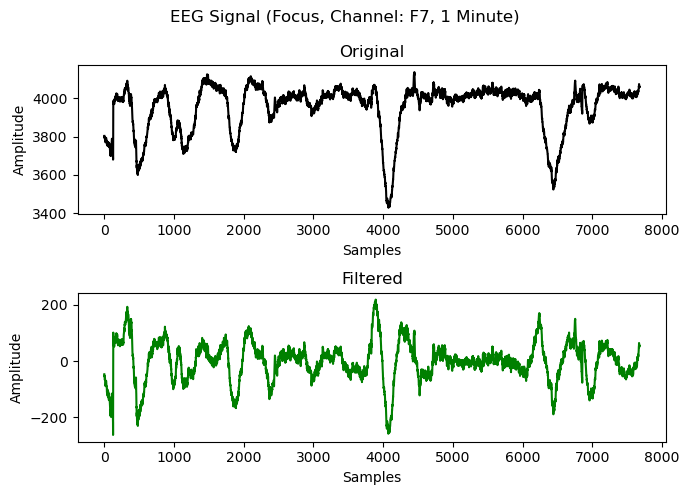

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))
fig.suptitle('EEG Signal (Focus, Channel: F7, 1 Minute)')

ax1.plot(focus_raw['eeg_record3'][0:1 * 128 * 60, 0], color='black')
ax1.set_title('Original')
ax1.set_xlabel('Samples')
ax1.set_ylabel('Amplitude')

ax2.plot(focus_filtered['eeg_record3'][:1 * 128 * 60, 0], color='green')
ax2.set_title('Filtered')
ax2.set_xlabel('Samples')
ax2.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

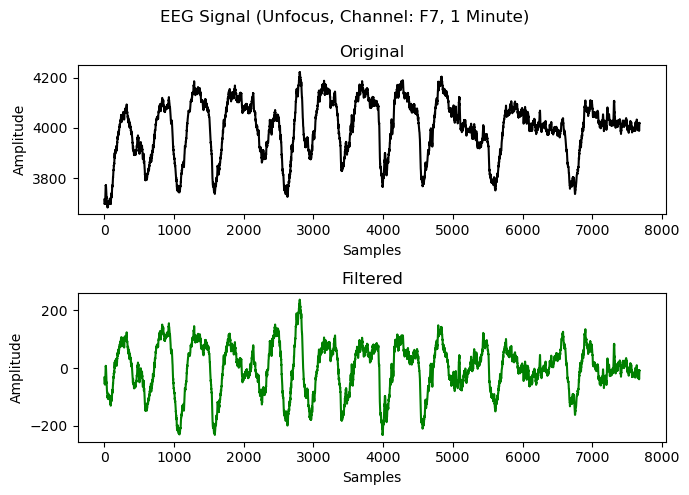

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))
fig.suptitle('EEG Signal (Unfocus, Channel: F7, 1 Minute)')

ax1.plot(unfocus_raw['eeg_record3'][0:1 * 128 * 60, 0], color='black')
ax1.set_title('Original')
ax1.set_xlabel('Samples')
ax1.set_ylabel('Amplitude')

ax2.plot(unfocus_filtered['eeg_record3'][:1 * 128 * 60, 0], color='green')
ax2.set_title('Filtered')
ax2.set_xlabel('Samples')
ax2.set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

### Apply STFT based on author's parameters settings

In [6]:
focus_power = {}
unfocus_power = {}

for recordname in focus_filtered:
    focus_power[recordname] = np.zeros([len(useful_channel), 513, 601])
    unfocus_power[recordname] = np.zeros([len(useful_channel), 513, 601])
    for channel in range(len(useful_channel)):
        f, t, Zxx1 = signal.stft(focus_filtered[recordname][:, channel], fs=128, window=signal.windows.blackman(128), nperseg=128, nfft=1024, noverlap=0)
        f, t, Zxx2 = signal.stft(unfocus_filtered[recordname][:, channel], fs=128, window=signal.windows.blackman(128), nperseg=128, nfft=1024, noverlap=0)
        focus_power[recordname][channel, :, :] = np.abs(Zxx1) ** 2
        unfocus_power[recordname][channel, :, :] = np.abs(Zxx2) ** 2

### Image about STFT

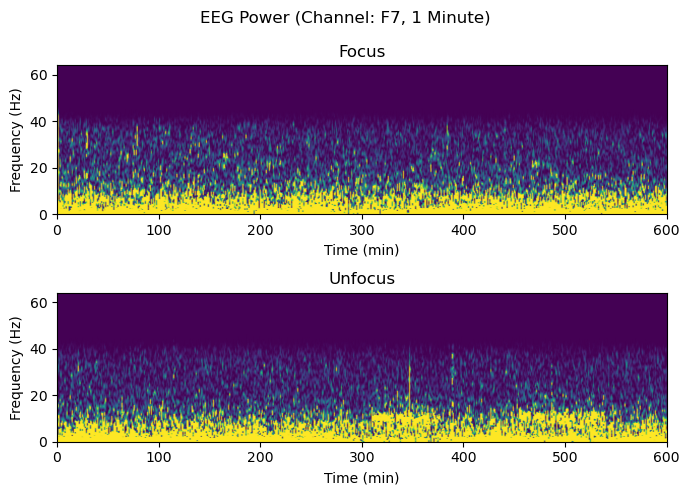

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))
fig.suptitle('EEG Power (Channel: F7, 1 Minute)')

ax1.pcolormesh(t, f, focus_power['eeg_record3'][0, 0:1 * 128 * 60, :], vmin=0, vmax=2 * np.sqrt(2), shading='gouraud')
ax1.set_title('Focus')
ax1.set_xlabel('Time (min)')
ax1.set_ylabel('Frequency (Hz)')

ax2.pcolormesh(t, f, unfocus_power['eeg_record3'][0, 0:1 * 128 * 60, :], vmin=0, vmax=2*np.sqrt(2), shading='gouraud')
ax2.set_title('Unfocus')
ax2.set_xlabel('Time (min)')
ax2.set_ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

### Retains frequencies from 0 to 18Hz, binned at 0.5Hz intervals (in total 36 bins)

In [8]:
focus_power_bin = {}
unfocus_power_bin = {}

for recordname in focus_power:
    focus_power_bin[recordname] = np.zeros([len(useful_channel), 36, 601])
    unfocus_power_bin[recordname] = np.zeros([len(useful_channel), 36, 601])
    for channel in range(len(useful_channel)):
        bin_num = 0
        for i in range(1, 144, 4):
            focus_power_bin[recordname][channel, bin_num, :] = np.average(focus_power[recordname][channel, i:i+4, :], axis=0)
            unfocus_power_bin[recordname][channel, bin_num, :] = np.average(unfocus_power[recordname][channel, i:i+4, :], axis=0)
            bin_num += 1

### Apply sliding window of 15 seconds length

In [9]:
focus_power_win = {}
unfocus_power_win = {}

for recordname in focus_power:
    focus_power_win[recordname] = np.zeros([len(useful_channel), 36, 585])
    unfocus_power_win[recordname] = np.zeros([len(useful_channel), 36, 585])
    for channel in range(len(useful_channel)):
        win_num = 0
        for i in range(585):
            focus_power_win[recordname][channel, :, win_num] = np.average(focus_power_bin[recordname][channel, :, i:i+15], axis=1)
            unfocus_power_win[recordname][channel, :, win_num] = np.average(unfocus_power_bin[recordname][channel, :, i:i+15], axis=1)
            win_num += 1

### Flatten first 2 dimensions (Channels and bins)

In [10]:
focus_data = {} 
unfocus_data = {}

for recordname in focus_power_win:
    focus_data[recordname] = np.zeros([252, 585])
    unfocus_data[recordname] = np.zeros([252, 585])
    for i in range(585):
        focus_data[recordname][:, i] = focus_power_win[recordname][:, :, i].reshape(1, -1)
        unfocus_data[recordname][:, i] = unfocus_power_win[recordname][:, :, i].reshape(1, -1)
    focus_data[recordname] = 10 * np.log10(focus_data[recordname])
    unfocus_data[recordname] = 10 * np.log10(unfocus_data[recordname])

### Plot the image after binning and applying window

Text(0.5, 1.0, 'EEG Power (Channel: F7, 0.5 Bin)')

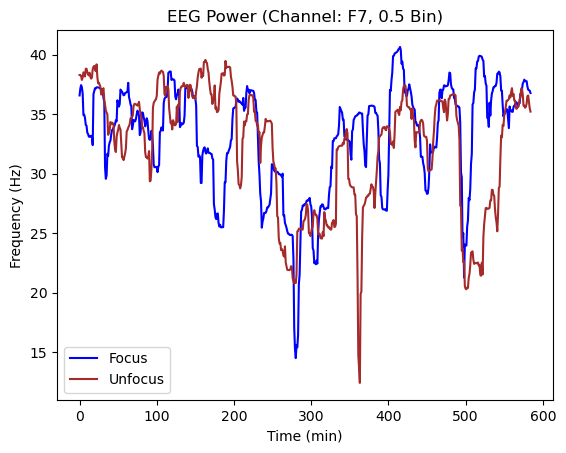

In [11]:
plt.plot(focus_data['eeg_record3'][0, :], color='blue', label='Focus')
plt.plot(unfocus_data['eeg_record3'][0, :], color='brown', label='Unfocus')
plt.legend()
plt.xlabel('Time (min)')
plt.ylabel('Frequency (Hz)')
plt.title('EEG Power (Channel: F7, 0.5 Bin)')

### Rebuild data structure, use different bins of channel data as input features

#### (We have 36 bins and 7 channels, so the size of features should be 36 * 7 = 252)

In [12]:
X = np.array([]).reshape(252, 0).copy()
y = []
for recordname in focus_data:
    X = np.concatenate((X, focus_data[recordname]), axis=1)
    X = np.concatenate((X, unfocus_data[recordname]), axis=1)
    y = y + [1] * 585 + [0] * 585

X = X.T
y = np.array(y)

### Split trainset and testset. Use 80% random data for training and the rest 20% for testing

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# I try to use the last day data of each subject for testing, but got a bad result

# test_files = ['eeg_record7', 'eeg_record14', 'eeg_record21', 'eeg_record27', 'eeg_record34']
# train_files = list(set(focus_data.keys()) - set(test_files))

# X_train = np.array([]).reshape(252, 0)
# y_train = []
# for recordname in train_files:
#     X_train = np.concatenate((X_train, focus_data[recordname]), axis=1)
#     X_train = np.concatenate((X_train, unfocus_data[recordname]), axis=1)
#     y_train = y_train + [1] * 585 + [0] * 585
# X_train = X_train.T

# X_test = np.array([]).reshape(252, 0)
# y_test = []
# for recordname in test_files:
#     X_test = np.concatenate((X_test, focus_data[recordname]), axis=1)
#     X_test = np.concatenate((X_test, unfocus_data[recordname]), axis=1)
#     y_test = y_test + [1] * 585 + [0] * 585
# X_test = X_test.T

### Import libraries and standardize data

In [15]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearnex import patch_sklearn, config_context
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Standardize data

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
# np.save('./X_train.npy', X_train)
# np.save('./X_test.npy', X_test)
# np.save('./y_train.npy', y_train)
# np.save('./y_test.npy', y_test)

# X_train = np.load('./X_train.npy')
# X_test = np.load('./X_test.npy')
# y_train = np.load('./y_train.npy')
# y_test = np.load('./y_test.npy')

### Try Decision Tree

In [18]:
from sklearn.tree import DecisionTreeClassifier

model_DT = DecisionTreeClassifier(criterion='entropy', random_state=42)

starttime = time.time()
model_DT.fit(X_train, y_train)
endtime = time.time()
training_time_DT = endtime - starttime

In [19]:
y_pred_DT = model_DT.predict(X_test)
y_proba_DT = model_DT.predict_proba(X_test)[:, 1]
acc_DT = accuracy_score(y_test, y_pred_DT)
precision_DT = precision_score(y_test, y_pred_DT, pos_label=1)
recall_DT = recall_score(y_test, y_pred_DT, pos_label=1)
f1_DT = f1_score(y_test, y_pred_DT, pos_label=1)
fpr_DT, tpr_DT, _ = roc_curve(y_test, y_proba_DT)
roc_auc_DT = auc(fpr_DT, tpr_DT)

print('Accuracy:', acc_DT)

Accuracy: 0.9358974358974359


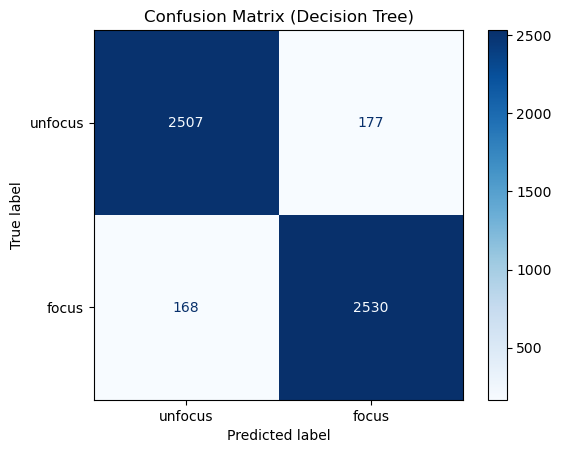

In [20]:
conf_matrix_DT = confusion_matrix(y_test, y_pred_DT)
dist = ConfusionMatrixDisplay(conf_matrix_DT, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (Decision Tree)')
plt.show()

### Try Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

model_RF = RandomForestClassifier(criterion='entropy', random_state=42)

starttime = time.time()
model_RF.fit(X_train, y_train)
endtime = time.time()
training_time_RF = endtime - starttime

In [22]:
y_pred_RF = model_RF.predict(X_test)
y_proba_RF = model_RF.predict_proba(X_test)[:, 1]
acc_RF = accuracy_score(y_test, y_pred_RF)
precision_RF = precision_score(y_test, y_pred_RF, pos_label=1)
recall_RF = recall_score(y_test, y_pred_RF, pos_label=1)
f1_RF = f1_score(y_test, y_pred_RF, pos_label=1)
fpr_RF, tpr_RF, _ = roc_curve(y_test, y_proba_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)

print('Accuracy:', acc_RF)

Accuracy: 0.9923820141211446


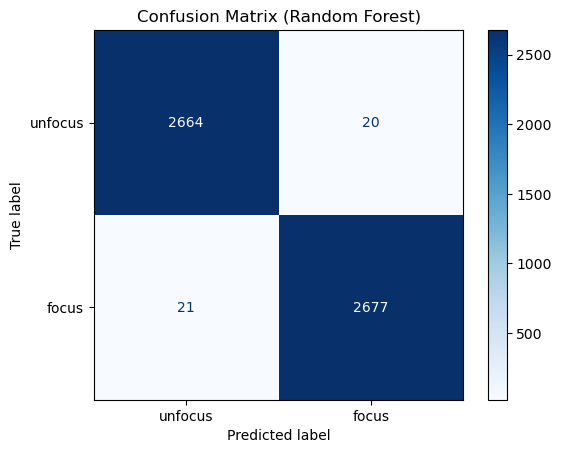

In [23]:
conf_matrix_RF = confusion_matrix(y_test, y_pred_RF)
dist = ConfusionMatrixDisplay(conf_matrix_RF, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

### Try KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier

model_KNN = KNeighborsClassifier(n_neighbors=5)

starttime = time.time()
model_KNN.fit(X_train, y_train)
endtime = time.time()
training_time_KNN = endtime - starttime

In [25]:
y_pred_KNN = model_KNN.predict(X_test)
y_proba_KNN = model_KNN.predict_proba(X_test)[:, 1]
acc_KNN = accuracy_score(y_test, y_pred_KNN)
precision_KNN = precision_score(y_test, y_pred_KNN, pos_label=1)
recall_KNN = recall_score(y_test, y_pred_KNN, pos_label=1)
f1_KNN = f1_score(y_test, y_pred_KNN, pos_label=1)
fpr_KNN, tpr_KNN, _ = roc_curve(y_test, y_proba_KNN)
roc_auc_KNN = auc(fpr_KNN, tpr_KNN)

print('Accuracy:', acc_KNN)

Accuracy: 0.998513563730955


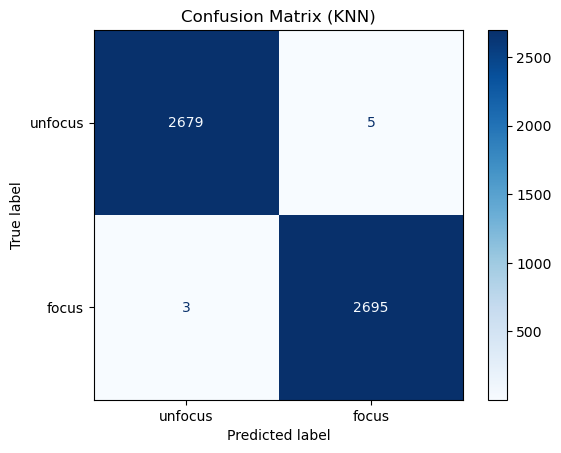

In [26]:
conf_matrix_KNN = confusion_matrix(y_test, y_pred_KNN)
dist = ConfusionMatrixDisplay(conf_matrix_KNN, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (KNN)')
plt.show()

### Try Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

model_LR = LogisticRegression(max_iter=2000)

starttime = time.time()
model_LR.fit(X_train, y_train)
endtime = time.time()
training_time_LR = endtime - starttime

In [28]:
y_pred_LR = model_LR.predict(X_test)
y_proba_LR = model_LR.predict_proba(X_test)[:, 1]
acc_LR = accuracy_score(y_test, y_pred_LR)
precision_LR = precision_score(y_test, y_pred_LR, pos_label=1)
recall_LR = recall_score(y_test, y_pred_LR, pos_label=1)
f1_LR = f1_score(y_test, y_pred_LR, pos_label=1)
fpr_LR, tpr_LR, _ = roc_curve(y_test, y_proba_LR)
roc_auc_LR = auc(fpr_LR, tpr_LR)

print('Accuracy:', acc_LR)

Accuracy: 0.7980304719435154


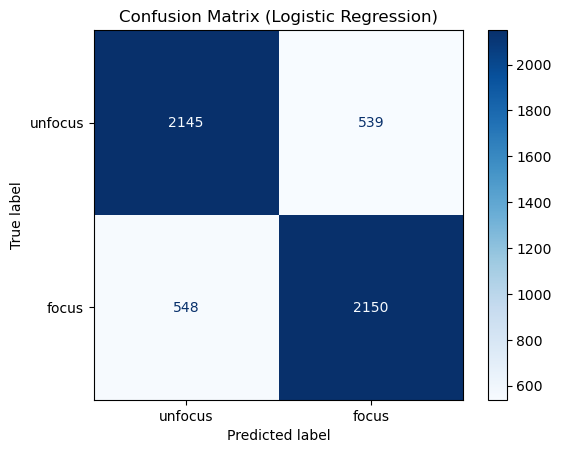

In [29]:
conf_matrix_LR = confusion_matrix(y_test, y_pred_LR)
dist = ConfusionMatrixDisplay(conf_matrix_LR, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()

### Try SVM

In [30]:
from sklearn.svm import SVC

model_SVM = SVC(kernel='rbf', random_state=42, probability=True)

starttime = time.time()
model_SVM.fit(X_train, y_train)
endtime = time.time()
training_time_SVM = endtime - starttime

In [31]:
y_pred_SVM = model_SVM.predict(X_test)
y_proba_SVM = model_SVM.predict_proba(X_test)[:, 1]
acc_SVM = accuracy_score(y_test, y_pred_SVM)
precision_SVM = precision_score(y_test, y_pred_SVM, pos_label=1)
recall_SVM = recall_score(y_test, y_pred_SVM, pos_label=1)
f1_SVM = f1_score(y_test, y_pred_SVM, pos_label=1)
fpr_SVM, tpr_SVM, _ = roc_curve(y_test, y_proba_SVM)
roc_auc_SVM = auc(fpr_SVM, tpr_SVM)

print('Accuracy:', acc_SVM)

Accuracy: 0.9669267930137495


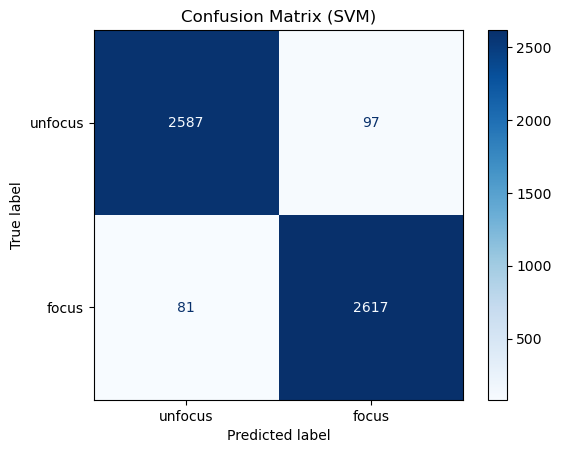

In [32]:
conf_matrix_SVM = confusion_matrix(y_test, y_pred_SVM)
dist = ConfusionMatrixDisplay(conf_matrix_SVM, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (SVM)')
plt.show()

### Try ResNet-18

Importing Data...

Model Training:
[Epoch 1/50] -> Train Loss: 0.5198, Test Loss: 0.3108, Acc: 0.8712%
[Epoch 2/50] -> Train Loss: 0.2091, Test Loss: 0.1247, Acc: 0.9517%
[Epoch 3/50] -> Train Loss: 0.0936, Test Loss: 0.0734, Acc: 0.9734%
[Epoch 4/50] -> Train Loss: 0.0529, Test Loss: 0.0509, Acc: 0.9822%
[Epoch 5/50] -> Train Loss: 0.0414, Test Loss: 0.0704, Acc: 0.9783%
[Epoch 6/50] -> Train Loss: 0.0367, Test Loss: 0.0675, Acc: 0.9773%
[Epoch 7/50] -> Train Loss: 0.0268, Test Loss: 0.0259, Acc: 0.9929%
[Epoch 8/50] -> Train Loss: 0.0222, Test Loss: 0.0360, Acc: 0.9883%
[Epoch 9/50] -> Train Loss: 0.0248, Test Loss: 0.0303, Acc: 0.9905%
[Epoch 10/50] -> Train Loss: 0.0174, Test Loss: 0.0346, Acc: 0.9877%
[Epoch 11/50] -> Train Loss: 0.0202, Test Loss: 0.0378, Acc: 0.9887%
[Epoch 12/50] -> Train Loss: 0.0143, Test Loss: 0.0190, Acc: 0.9933%
[Epoch 13/50] -> Train Loss: 0.0152, Test Loss: 0.0234, Acc: 0.9918%
[Epoch 14/50] -> Train Loss: 0.0176, Test Loss: 0.0273, Acc: 0.9902%
[Epoch 1

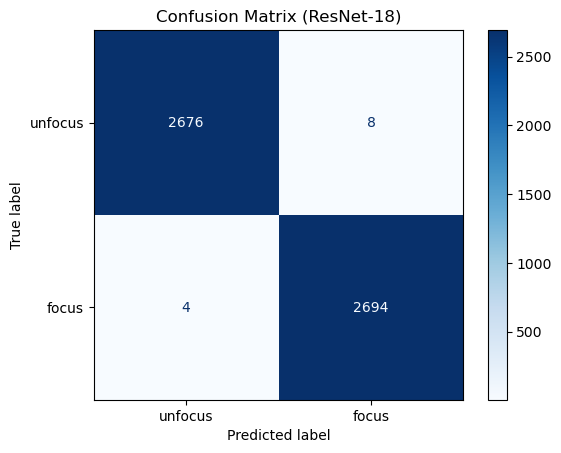

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
from torchvision.models import resnet18
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

class CustomDataset(Dataset):
    def __init__(self, X, y, transform):
        self.samples = []
        self.labels = []
        self.transform = transform
        
        for i in range(len(X)):
            sample = X[i].reshape((18, 14))
            # Reshape sample to (224, 224, 3)
            sample_resized = np.resize(sample, (224, 224))
            sample_resized = np.repeat(sample_resized[:, :, np.newaxis], 3, axis=2)
            sample_resized = sample_resized.astype(np.float32)
            sample_tensor = self.transform(sample_resized)
            
            self.samples.append(sample_tensor)
            self.labels.append(torch.tensor(y[i], dtype=torch.long))
            
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)


def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    predicted_labels = []
    true_labels = []
    predicted_proba = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            predicted_proba.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    
    cm = confusion_matrix(true_labels, predicted_labels)
    
    return running_loss / len(test_loader), accuracy, precision, recall, f1, cm, predicted_proba


batch_size = 32
learning_rate = 0.001
num_epochs = 50

train_info = pd.DataFrame(columns=['epoch', 'train_loss', 'lr', 'test_loss', 'test_acc', 'precision', 'recall', 'f1', 'time'])

torch.manual_seed(2024)
# Set GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data preprocessing transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create train and test data loaders
print("Importing Data...")
train_dataset = CustomDataset(X_train.copy(), y_train.copy(), transform=transform)
test_dataset = CustomDataset(X_test.copy(), y_test.copy(), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# Create model instance and move it to GPU
model = resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

best_accuracy = 0
# Model training
print("\nModel Training:")
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy, precision, recall, f1, cm, proba = test(model, test_loader, criterion, device)
    end_time = time.time()
    epoch_training_time = end_time - start_time
    train_info.loc[epoch] = [epoch + 1, train_loss, optimizer.state_dict()['param_groups'][0]['lr'], test_loss, test_accuracy, precision, recall, f1, epoch_training_time]
    scheduler.step()
    print(f'[Epoch {epoch + 1}/{num_epochs}] -> Train Loss: {train_loss:.4f}, ', end='')
    print(f'Test Loss: {test_loss:.4f}, Acc: {test_accuracy:.4f}%')
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_cm = cm
        best_proba = proba
        torch.save(model.state_dict(), './model/resnet18_model_part_detrend_plr_stft_bin_win.pth')

positive_probs = [prob[1] for prob in best_proba]
negative_probs = [1 - prob[1] for prob in best_proba]
y_proba_resnet18 = np.column_stack((negative_probs, positive_probs))
fpr_resnet18, tpr_resnet18, _ = roc_curve(y_test, y_proba_resnet18[:, 1])
roc_auc_resnet18 = auc(fpr_resnet18, tpr_resnet18)

train_info.to_excel('./result/train_info_resnet18_part_detrend_plr_stft_bin_win.xlsx', index=False)
print(f'\nBest Accuracy: {best_accuracy:.4f}%')
dist = ConfusionMatrixDisplay(best_cm, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (ResNet-18)')
plt.show()

### Try GoogLeNet

Importing Data...

Model Training:
[Epoch 1/50] -> Train Loss: 0.3388, Test Loss: 0.1512, Acc: 0.9394%
[Epoch 2/50] -> Train Loss: 0.1072, Test Loss: 0.0551, Acc: 0.9818%
[Epoch 3/50] -> Train Loss: 0.0555, Test Loss: 0.0464, Acc: 0.9857%
[Epoch 4/50] -> Train Loss: 0.0417, Test Loss: 0.0370, Acc: 0.9876%
[Epoch 5/50] -> Train Loss: 0.0283, Test Loss: 0.0258, Acc: 0.9920%
[Epoch 6/50] -> Train Loss: 0.0244, Test Loss: 0.0240, Acc: 0.9922%
[Epoch 7/50] -> Train Loss: 0.0220, Test Loss: 0.0327, Acc: 0.9900%
[Epoch 8/50] -> Train Loss: 0.0230, Test Loss: 0.0422, Acc: 0.9842%
[Epoch 9/50] -> Train Loss: 0.0177, Test Loss: 0.0165, Acc: 0.9939%
[Epoch 10/50] -> Train Loss: 0.0154, Test Loss: 0.0349, Acc: 0.9889%
[Epoch 11/50] -> Train Loss: 0.0163, Test Loss: 0.0260, Acc: 0.9900%
[Epoch 12/50] -> Train Loss: 0.0164, Test Loss: 0.0237, Acc: 0.9924%
[Epoch 13/50] -> Train Loss: 0.0158, Test Loss: 0.0240, Acc: 0.9922%
[Epoch 14/50] -> Train Loss: 0.0149, Test Loss: 0.0311, Acc: 0.9902%
[Epoch 1

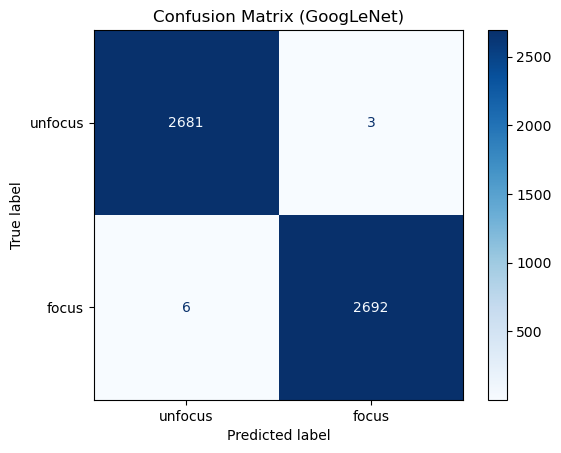

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
from torchvision.models import googlenet
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

class CustomDataset(Dataset):
    def __init__(self, X, y, transform):
        self.samples = []
        self.labels = []
        self.transform = transform
        
        for i in range(len(X)):
            sample = X[i].reshape((18, 14))
            # Reshape sample to (224, 224, 3)
            sample_resized = np.resize(sample, (224, 224))
            sample_resized = np.repeat(sample_resized[:, :, np.newaxis], 3, axis=2)
            sample_resized = sample_resized.astype(np.float32)
            sample_tensor = self.transform(sample_resized)
            
            self.samples.append(sample_tensor)
            self.labels.append(torch.tensor(y[i], dtype=torch.long))
            
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)


def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    predicted_labels = []
    true_labels = []
    predicted_proba = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            predicted_proba.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    
    cm = confusion_matrix(true_labels, predicted_labels)
    
    return running_loss / len(test_loader), accuracy, precision, recall, f1, cm, predicted_proba


batch_size = 32
learning_rate = 0.001
num_epochs = 50

train_info = pd.DataFrame(columns=['epoch', 'train_loss', 'lr', 'test_loss', 'test_acc', 'precision', 'recall', 'f1', 'time'])

torch.manual_seed(2024)
# Set GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data preprocessing transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create train and test data loaders
print("Importing Data...")
train_dataset = CustomDataset(X_train.copy(), y_train.copy(), transform=transform)
test_dataset = CustomDataset(X_test.copy(), y_test.copy(), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# Create model instance and move it to GPU
model = googlenet(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
# Remove the last pooling layer
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

best_accuracy = 0
# Model training
print("\nModel Training:")
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy, precision, recall, f1, cm, proba = test(model, test_loader, criterion, device)
    end_time = time.time()
    epoch_training_time = end_time - start_time
    train_info.loc[epoch] = [epoch + 1, train_loss, optimizer.state_dict()['param_groups'][0]['lr'], test_loss, test_accuracy, precision, recall, f1, epoch_training_time]
    scheduler.step()
    print(f'[Epoch {epoch + 1}/{num_epochs}] -> Train Loss: {train_loss:.4f}, ', end='')
    print(f'Test Loss: {test_loss:.4f}, Acc: {test_accuracy:.4f}%')
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_cm = cm
        best_proba = proba
        torch.save(model.state_dict(), './model/googlenet_model_part_detrend_plr_stft_bin_win.pth')

positive_probs = [prob[1] for prob in best_proba]
negative_probs = [1 - prob[1] for prob in best_proba]
y_proba_googlenet = np.column_stack((negative_probs, positive_probs))
fpr_googlenet, tpr_googlenet, _ = roc_curve(y_test, y_proba_googlenet[:, 1])
roc_auc_googlenet = auc(fpr_googlenet, tpr_googlenet)

train_info.to_excel('./result/train_info_googlenet_part_detrend_plr_stft_bin_win.xlsx', index=False)
print(f'\nBest Accuracy: {best_accuracy:.4f}%')
dist = ConfusionMatrixDisplay(best_cm, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (GoogLeNet)')
plt.show()

### Go back to original method, try to apply feature reduction methods

### ANOVA

In [36]:
from sklearn.feature_selection  import f_classif

F_statistic, p_values = f_classif(X_train, y_train)
selected_features = p_values < 0.05
X_train_anova = X_train[:, selected_features]
X_test_anova = X_test[:, selected_features]
X_train_anova.shape

(21528, 216)

### Feature Importance Method

In [37]:
from sklearn.ensemble import RandomForestClassifier

model_RF_temp = RandomForestClassifier(random_state=42)
model_RF_temp.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [38]:
importances = model_RF_temp.feature_importances_
selected_features = importances > np.mean(importances)
X_train_fi = X_train[:, selected_features]
X_test_fi = X_test[:, selected_features]
X_train_fi.shape

(21528, 82)

### Linear Correlation Coefficient

In [39]:
from scipy.stats import pearsonr

n_features = X_train.shape[1]
correlations = []

for i in range(n_features):
    corr, p_value = pearsonr(X_train[:, i], y_train)
    correlations.append((i, corr, p_value))

correlations.sort(key=lambda x: abs(x[1]), reverse=True)

threshold = np.mean([abs(corr) for _, corr, _ in correlations])
selected_features = [i for i, corr, p_value in correlations if abs(corr) > threshold]

X_train_lcc = X_train[:, selected_features]
X_test_lcc = X_test[:, selected_features]
X_train_lcc.shape

(21528, 108)

### PCA

In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components='mle')
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_train_pca.shape

(21528, 251)

### Plot the data reduction rate

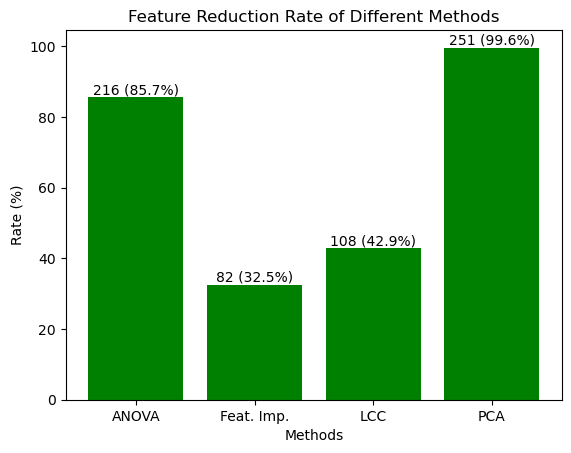

In [41]:
reduction_method = ['ANOVA', 'Feat. Imp.', 'LCC', 'PCA']
reduction_num = [X_train_anova.shape[1], X_train_fi.shape[1], X_train_lcc.shape[1], X_train_pca.shape[1]]
reduction_rate = [x / X_train.shape[1] * 100 for x in reduction_num]
labels = [f"{num} ({rate:.1f}%)" for num, rate in zip(reduction_num, reduction_rate)]
plt.bar_label(plt.bar(reduction_method, reduction_rate, color='green'), labels=labels)
plt.xlabel('Methods')
plt.ylabel('Rate (%)')
plt.title('Feature Reduction Rate of Different Methods')
plt.show()

### Also, try Decision Tree

In [42]:
model_DT_anova = DecisionTreeClassifier(criterion='entropy', random_state=42)
model_DT_fi = DecisionTreeClassifier(criterion='entropy', random_state=42)
model_DT_lcc = DecisionTreeClassifier(criterion='entropy', random_state=42)
model_DT_pca = DecisionTreeClassifier(criterion='entropy', random_state=42)

starttime = time.time()
model_DT_anova.fit(X_train_anova, y_train)
endtime = time.time()
training_time_DT_anova = endtime - starttime

starttime = time.time()
model_DT_fi.fit(X_train_fi, y_train)
endtime = time.time()
training_time_DT_fi = endtime - starttime

starttime = time.time()
model_DT_lcc.fit(X_train_lcc, y_train)
endtime = time.time()
training_time_DT_lcc = endtime - starttime

starttime = time.time()
model_DT_pca.fit(X_train_pca, y_train)
endtime = time.time()
training_time_DT_pca = endtime - starttime

In [43]:
y_pred_DT_anova = model_DT_anova.predict(X_test_anova)
y_proba_DT_anova = model_DT_anova.predict_proba(X_test_anova)[:, 1]
acc_DT_anova = accuracy_score(y_test, y_pred_DT_anova)
precision_DT_anova = precision_score(y_test, y_pred_DT_anova, pos_label=1)
recall_DT_anova = recall_score(y_test, y_pred_DT_anova, pos_label=1)
f1_DT_anova = f1_score(y_test, y_pred_DT_anova, pos_label=1)
fpr_DT_anova, tpr_DT_anova, _ = roc_curve(y_test, y_proba_DT_anova)
roc_auc_DT_anova = auc(fpr_DT_anova, tpr_DT_anova)

y_pred_DT_fi = model_DT_fi.predict(X_test_fi)
y_proba_DT_fi = model_DT_fi.predict_proba(X_test_fi)[:, 1]
acc_DT_fi = accuracy_score(y_test, y_pred_DT_fi)
precision_DT_fi = precision_score(y_test, y_pred_DT_fi, pos_label=1)
recall_DT_fi = recall_score(y_test, y_pred_DT_fi, pos_label=1)
f1_DT_fi = f1_score(y_test, y_pred_DT_fi, pos_label=1)
fpr_DT_fi, tpr_DT_fi, _ = roc_curve(y_test, y_proba_DT_fi)
roc_auc_DT_fi = auc(fpr_DT_fi, tpr_DT_fi)

y_pred_DT_lcc = model_DT_lcc.predict(X_test_lcc)
y_proba_DT_lcc = model_DT_lcc.predict_proba(X_test_lcc)[:, 1]
acc_DT_lcc = accuracy_score(y_test, y_pred_DT_lcc)
precision_DT_lcc = precision_score(y_test, y_pred_DT_lcc, pos_label=1)
recall_DT_lcc = recall_score(y_test, y_pred_DT_lcc, pos_label=1)
f1_DT_lcc = f1_score(y_test, y_pred_DT_lcc, pos_label=1)
fpr_DT_lcc, tpr_DT_lcc, _ = roc_curve(y_test, y_proba_DT_lcc)
roc_auc_DT_lcc = auc(fpr_DT_lcc, tpr_DT_lcc)

y_pred_DT_pca = model_DT_pca.predict(X_test_pca)
y_proba_DT_pca = model_DT_pca.predict_proba(X_test_pca)[:, 1]
acc_DT_pca = accuracy_score(y_test, y_pred_DT_pca)
precision_DT_pca = precision_score(y_test, y_pred_DT_pca, pos_label=1)
recall_DT_pca = recall_score(y_test, y_pred_DT_pca, pos_label=1)
f1_DT_pca = f1_score(y_test, y_pred_DT_pca, pos_label=1)
fpr_DT_pca, tpr_DT_pca, _ = roc_curve(y_test, y_proba_DT_pca)
roc_auc_DT_pca = auc(fpr_DT_pca, tpr_DT_pca)

print('Accuracy(ANOVA):', acc_DT_anova)
print('Accuracy(Feature Importance):', acc_DT_fi)
print('Accuracy(Linear Correlation Coefficient):', acc_DT_lcc)
print('Accuracy(PCA):', acc_DT_pca)

Accuracy(ANOVA): 0.9360832404310665
Accuracy(Feature Importance): 0.9318097361575622
Accuracy(Linear Correlation Coefficient): 0.9251207729468599
Accuracy(PCA): 0.8827573392790784


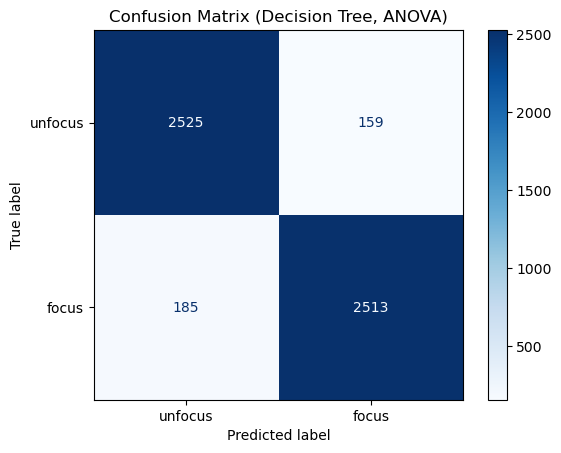

In [44]:
conf_matrix_DT_anova = confusion_matrix(y_test, y_pred_DT_anova)
dist = ConfusionMatrixDisplay(conf_matrix_DT_anova, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (Decision Tree, ANOVA)')
plt.show()

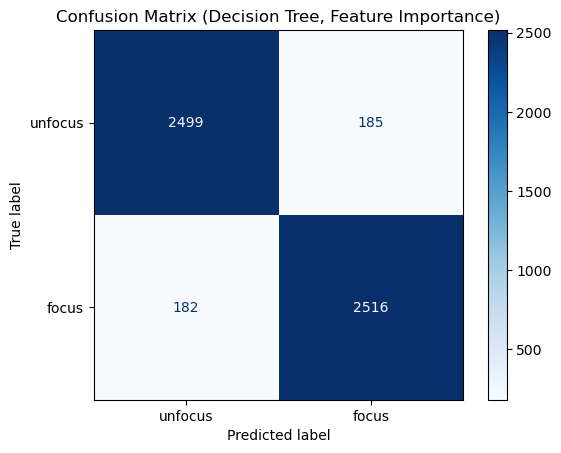

In [45]:
conf_matrix_DT_fi = confusion_matrix(y_test, y_pred_DT_fi)
dist = ConfusionMatrixDisplay(conf_matrix_DT_fi, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (Decision Tree, Feature Importance)')
plt.show()

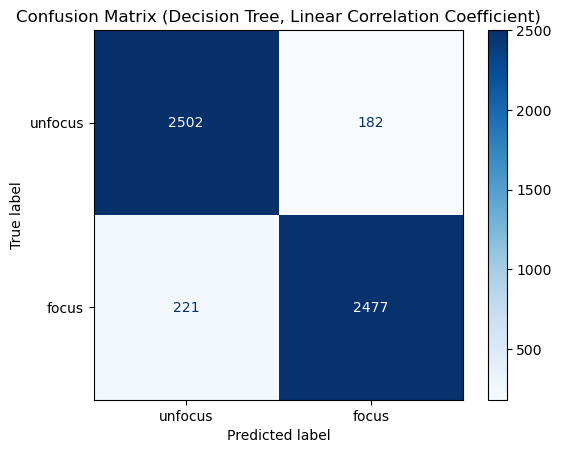

In [46]:
conf_matrix_DT_lcc = confusion_matrix(y_test, y_pred_DT_lcc)
dist = ConfusionMatrixDisplay(conf_matrix_DT_lcc, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (Decision Tree, Linear Correlation Coefficient)')
plt.show()

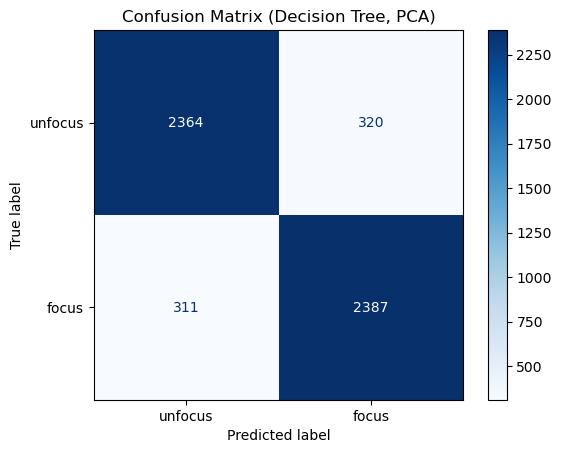

In [47]:
conf_matrix_DT_pca = confusion_matrix(y_test, y_pred_DT_pca)
dist = ConfusionMatrixDisplay(conf_matrix_DT_pca, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (Decision Tree, PCA)')
plt.show()

### Try Random Forest

In [48]:
model_RF_anova = RandomForestClassifier(criterion='entropy', random_state=42)
model_RF_fi = RandomForestClassifier(criterion='entropy', random_state=42)
model_RF_lcc = RandomForestClassifier(criterion='entropy', random_state=42)
model_RF_pca = RandomForestClassifier(criterion='entropy', random_state=42)

starttime = time.time()
model_RF_anova.fit(X_train_anova, y_train)
endtime = time.time()
training_time_RF_anova = endtime - starttime

starttime = time.time()
model_RF_fi.fit(X_train_fi, y_train)
endtime = time.time()
training_time_RF_fi = endtime - starttime

starttime = time.time()
model_RF_lcc.fit(X_train_lcc, y_train)
endtime = time.time()
training_time_RF_lcc = endtime - starttime

starttime = time.time()
model_RF_pca.fit(X_train_pca, y_train)
endtime = time.time()
training_time_RF_pca = endtime - starttime

In [49]:
y_pred_RF_anova = model_RF_anova.predict(X_test_anova)
y_proba_RF_anova = model_RF_anova.predict_proba(X_test_anova)[:, 1]
acc_RF_anova = accuracy_score(y_test, y_pred_RF_anova)
precision_RF_anova = precision_score(y_test, y_pred_RF_anova, pos_label=1)
recall_RF_anova = recall_score(y_test, y_pred_RF_anova, pos_label=1)
f1_RF_anova = f1_score(y_test, y_pred_RF_anova, pos_label=1)
fpr_RF_anova, tpr_RF_anova, _ = roc_curve(y_test, y_proba_RF_anova)
roc_auc_RF_anova = auc(fpr_RF_anova, tpr_RF_anova)

y_pred_RF_fi = model_RF_fi.predict(X_test_fi)
y_proba_RF_fi = model_RF_fi.predict_proba(X_test_fi)[:, 1]
acc_RF_fi = accuracy_score(y_test, y_pred_RF_fi)
precision_RF_fi = precision_score(y_test, y_pred_RF_fi, pos_label=1)
recall_RF_fi = recall_score(y_test, y_pred_RF_fi, pos_label=1)
f1_RF_fi = f1_score(y_test, y_pred_RF_fi, pos_label=1)
fpr_RF_fi, tpr_RF_fi, _ = roc_curve(y_test, y_proba_RF_fi)
roc_auc_RF_fi = auc(fpr_RF_fi, tpr_RF_fi)

y_pred_RF_lcc = model_RF_lcc.predict(X_test_lcc)
y_proba_RF_lcc = model_RF_lcc.predict_proba(X_test_lcc)[:, 1]
acc_RF_lcc = accuracy_score(y_test, y_pred_RF_lcc)
precision_RF_lcc = precision_score(y_test, y_pred_RF_lcc, pos_label=1)
recall_RF_lcc = recall_score(y_test, y_pred_RF_lcc, pos_label=1)
f1_RF_lcc = f1_score(y_test, y_pred_RF_lcc, pos_label=1)
fpr_RF_lcc, tpr_RF_lcc, _ = roc_curve(y_test, y_proba_RF_lcc)
roc_auc_RF_lcc = auc(fpr_RF_lcc, tpr_RF_lcc)

y_pred_RF_pca = model_RF_pca.predict(X_test_pca)
y_proba_RF_pca = model_RF_pca.predict_proba(X_test_pca)[:, 1]
acc_RF_pca = accuracy_score(y_test, y_pred_RF_pca)
precision_RF_pca = precision_score(y_test, y_pred_RF_pca, pos_label=1)
recall_RF_pca = recall_score(y_test, y_pred_RF_pca, pos_label=1)
f1_RF_pca = f1_score(y_test, y_pred_RF_pca, pos_label=1)
fpr_RF_pca, tpr_RF_pca, _ = roc_curve(y_test, y_proba_RF_pca)
roc_auc_RF_pca = auc(fpr_RF_pca, tpr_RF_pca)

print('Accuracy(ANOVA):', acc_RF_anova)
print('Accuracy(Feature Importance):', acc_RF_fi)
print('Accuracy(Linear Correlation Coefficient):', acc_RF_lcc)
print('Accuracy(PCA):', acc_RF_pca)

Accuracy(ANOVA): 0.9925678186547752
Accuracy(Feature Importance): 0.9884801189149015
Accuracy(Linear Correlation Coefficient): 0.9873652917131178
Accuracy(PCA): 0.9866220735785953


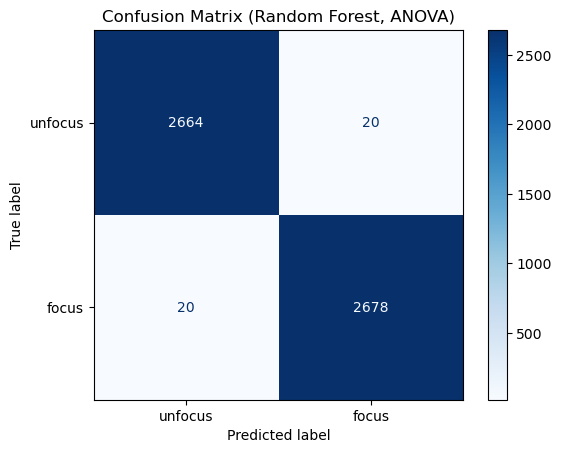

In [50]:
conf_matrix_RF_anova = confusion_matrix(y_test, y_pred_RF_anova)
dist = ConfusionMatrixDisplay(conf_matrix_RF_anova, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (Random Forest, ANOVA)')
plt.show()

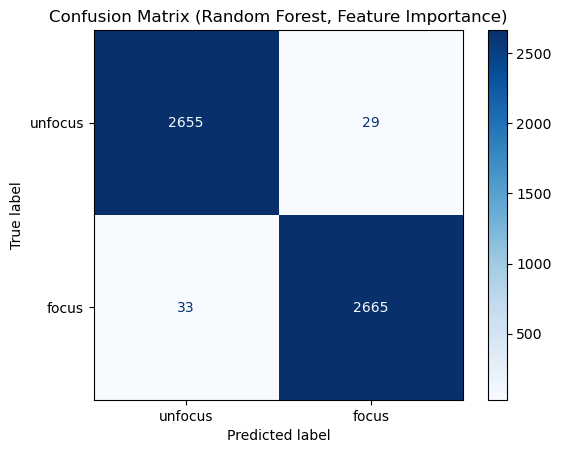

In [51]:
conf_matrix_RF_fi = confusion_matrix(y_test, y_pred_RF_fi)
dist = ConfusionMatrixDisplay(conf_matrix_RF_fi, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (Random Forest, Feature Importance)')
plt.show()

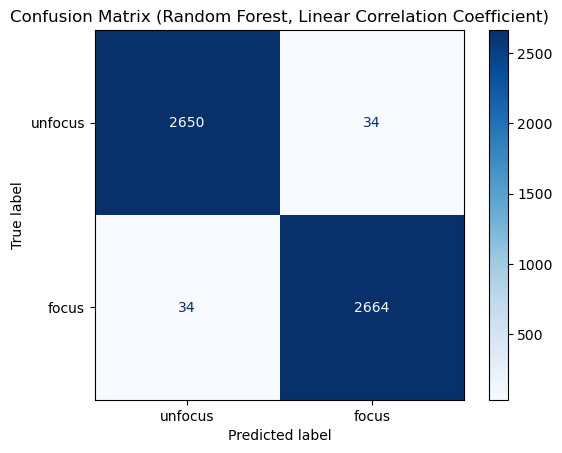

In [52]:
conf_matrix_RF_lcc = confusion_matrix(y_test, y_pred_RF_lcc)
dist = ConfusionMatrixDisplay(conf_matrix_RF_lcc, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (Random Forest, Linear Correlation Coefficient)')
plt.show()

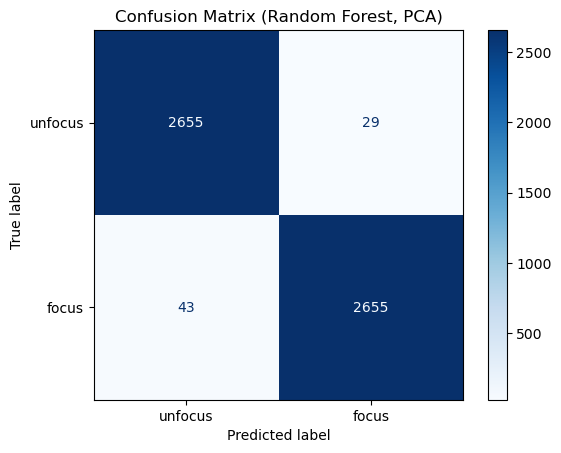

In [53]:
conf_matrix_RF_pca = confusion_matrix(y_test, y_pred_RF_pca)
dist = ConfusionMatrixDisplay(conf_matrix_RF_pca, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (Random Forest, PCA)')
plt.show()

### Try KNN

In [54]:
model_KNN_anova = KNeighborsClassifier(n_neighbors=5)
model_KNN_fi = KNeighborsClassifier(n_neighbors=5)
model_KNN_lcc = KNeighborsClassifier(n_neighbors=5)
model_KNN_pca = KNeighborsClassifier(n_neighbors=5)

starttime = time.time()
model_KNN_anova.fit(X_train_anova, y_train)
endtime = time.time()
training_time_KNN_anova = endtime - starttime

starttime = time.time()
model_KNN_fi.fit(X_train_fi, y_train)
endtime = time.time()
training_time_KNN_fi = endtime - starttime

starttime = time.time()
model_KNN_lcc.fit(X_train_lcc, y_train)
endtime = time.time()
training_time_KNN_lcc = endtime - starttime

starttime = time.time()
model_KNN_pca.fit(X_train_pca, y_train)
endtime = time.time()
training_time_KNN_pca = endtime - starttime

In [55]:
y_pred_KNN_anova = model_KNN_anova.predict(X_test_anova)
y_proba_KNN_anova = model_KNN_anova.predict_proba(X_test_anova)[:, 1]
acc_KNN_anova = accuracy_score(y_test, y_pred_KNN_anova)
precision_KNN_anova = precision_score(y_test, y_pred_KNN_anova, pos_label=1)
recall_KNN_anova = recall_score(y_test, y_pred_KNN_anova, pos_label=1)
f1_KNN_anova = f1_score(y_test, y_pred_KNN_anova, pos_label=1)
fpr_KNN_anova, tpr_KNN_anova, _ = roc_curve(y_test, y_proba_KNN_anova)
roc_auc_KNN_anova = auc(fpr_KNN_anova, tpr_KNN_anova)

y_pred_KNN_fi = model_KNN_fi.predict(X_test_fi)
y_proba_KNN_fi = model_KNN_fi.predict_proba(X_test_fi)[:, 1]
acc_KNN_fi = accuracy_score(y_test, y_pred_KNN_fi)
precision_KNN_fi = precision_score(y_test, y_pred_KNN_fi, pos_label=1)
recall_KNN_fi = recall_score(y_test, y_pred_KNN_fi, pos_label=1)
f1_KNN_fi = f1_score(y_test, y_pred_KNN_fi, pos_label=1)
fpr_KNN_fi, tpr_KNN_fi, _ = roc_curve(y_test, y_proba_KNN_fi)
roc_auc_KNN_fi = auc(fpr_KNN_fi, tpr_KNN_fi)

y_pred_KNN_lcc = model_KNN_lcc.predict(X_test_lcc)
y_proba_KNN_lcc = model_KNN_lcc.predict_proba(X_test_lcc)[:, 1]
acc_KNN_lcc = accuracy_score(y_test, y_pred_KNN_lcc)
precision_KNN_lcc = precision_score(y_test, y_pred_KNN_lcc, pos_label=1)
recall_KNN_lcc = recall_score(y_test, y_pred_KNN_lcc, pos_label=1)
f1_KNN_lcc = f1_score(y_test, y_pred_KNN_lcc, pos_label=1)
fpr_KNN_lcc, tpr_KNN_lcc, _ = roc_curve(y_test, y_proba_KNN_lcc)
roc_auc_KNN_lcc = auc(fpr_KNN_lcc, tpr_KNN_lcc)

y_pred_KNN_pca = model_KNN_pca.predict(X_test_pca)
y_proba_KNN_pca = model_KNN_pca.predict_proba(X_test_pca)[:, 1]
acc_KNN_pca = accuracy_score(y_test, y_pred_KNN_pca)
precision_KNN_pca = precision_score(y_test, y_pred_KNN_pca, pos_label=1)
recall_KNN_pca = recall_score(y_test, y_pred_KNN_pca, pos_label=1)
f1_KNN_pca = f1_score(y_test, y_pred_KNN_pca, pos_label=1)
fpr_KNN_pca, tpr_KNN_pca, _ = roc_curve(y_test, y_proba_KNN_pca)
roc_auc_KNN_pca = auc(fpr_KNN_pca, tpr_KNN_pca)

print('Accuracy(ANOVA):', acc_KNN_anova)
print('Accuracy(Feature Importance):', acc_KNN_fi)
print('Accuracy(Linear Correlation Coefficient):', acc_KNN_lcc)
print('Accuracy(PCA):', acc_KNN_pca)

Accuracy(ANOVA): 0.9977703455964325
Accuracy(Feature Importance): 0.9955406911928651
Accuracy(Linear Correlation Coefficient): 0.9957264957264957
Accuracy(PCA): 0.998513563730955


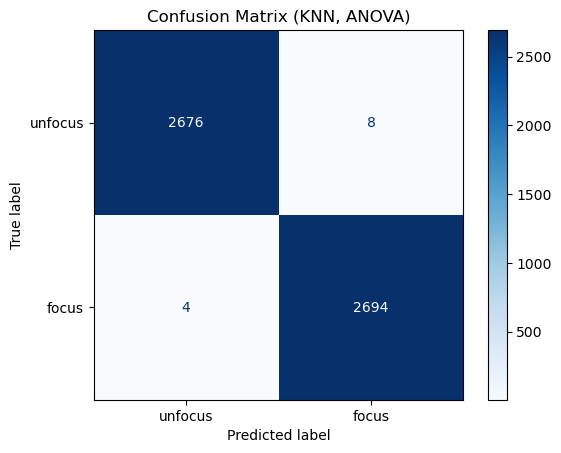

In [56]:
conf_matrix_KNN_anova = confusion_matrix(y_test, y_pred_KNN_anova)
dist = ConfusionMatrixDisplay(conf_matrix_KNN_anova, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (KNN, ANOVA)')
plt.show()

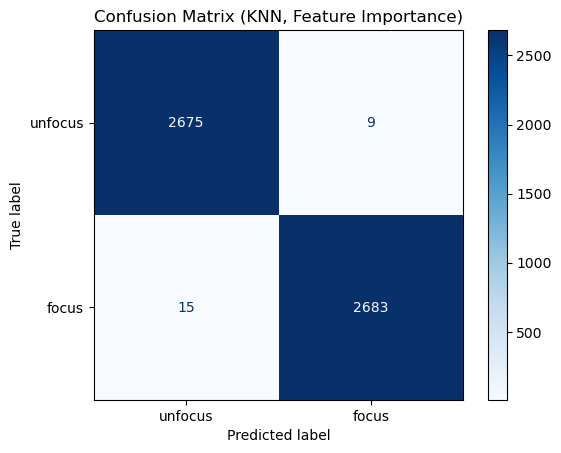

In [57]:
conf_matrix_KNN_fi = confusion_matrix(y_test, y_pred_KNN_fi)
dist = ConfusionMatrixDisplay(conf_matrix_KNN_fi, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (KNN, Feature Importance)')
plt.show()

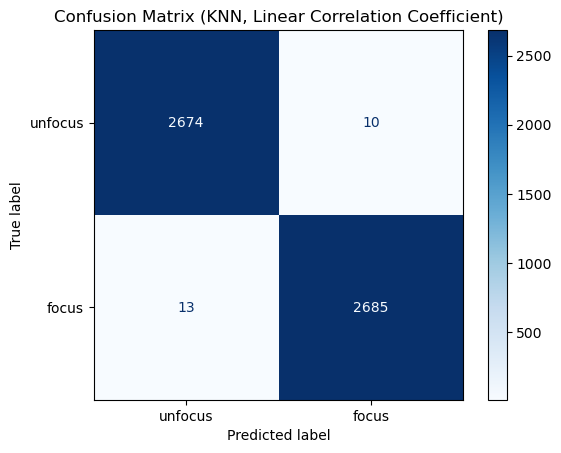

In [58]:
conf_matrix_KNN_lcc = confusion_matrix(y_test, y_pred_KNN_lcc)
dist = ConfusionMatrixDisplay(conf_matrix_KNN_lcc, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (KNN, Linear Correlation Coefficient)')
plt.show()

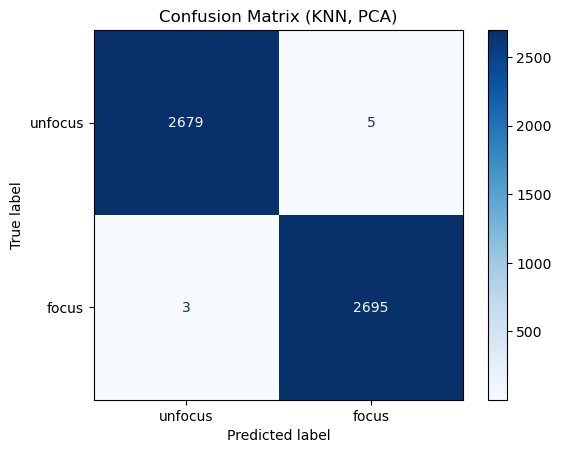

In [59]:
conf_matrix_KNN_pca = confusion_matrix(y_test, y_pred_KNN_pca)
dist = ConfusionMatrixDisplay(conf_matrix_KNN_pca, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (KNN, PCA)')
plt.show()

### Try Logisitc Regression

In [60]:
model_LR_anova = LogisticRegression(max_iter=2000)
model_LR_fi = LogisticRegression(max_iter=2000)
model_LR_lcc = LogisticRegression(max_iter=2000)
model_LR_pca = LogisticRegression(max_iter=2000)

starttime = time.time()
model_LR_anova.fit(X_train_anova, y_train)
endtime = time.time()
training_time_LR_anova = endtime - starttime

starttime = time.time()
model_LR_fi.fit(X_train_fi, y_train)
endtime = time.time()
training_time_LR_fi = endtime - starttime

starttime = time.time()
model_LR_lcc.fit(X_train_lcc, y_train)
endtime = time.time()
training_time_LR_lcc = endtime - starttime

starttime = time.time()
model_LR_pca.fit(X_train_pca, y_train)
endtime = time.time()
training_time_LR_pca = endtime - starttime

In [61]:
y_pred_LR_anova = model_LR_anova.predict(X_test_anova)
y_proba_LR_anova = model_LR_anova.predict_proba(X_test_anova)[:, 1]
acc_LR_anova = accuracy_score(y_test, y_pred_LR_anova)
precision_LR_anova = precision_score(y_test, y_pred_LR_anova, pos_label=1)
recall_LR_anova = recall_score(y_test, y_pred_LR_anova, pos_label=1)
f1_LR_anova = f1_score(y_test, y_pred_LR_anova, pos_label=1)
fpr_LR_anova, tpr_LR_anova, _ = roc_curve(y_test, y_proba_LR_anova)
roc_auc_LR_anova = auc(fpr_LR_anova, tpr_LR_anova)

y_pred_LR_fi = model_LR_fi.predict(X_test_fi)
y_proba_LR_fi = model_LR_fi.predict_proba(X_test_fi)[:, 1]
acc_LR_fi = accuracy_score(y_test, y_pred_LR_fi)
precision_LR_fi = precision_score(y_test, y_pred_LR_fi, pos_label=1)
recall_LR_fi = recall_score(y_test, y_pred_LR_fi, pos_label=1)
f1_LR_fi = f1_score(y_test, y_pred_LR_fi, pos_label=1)
fpr_LR_fi, tpr_LR_fi, _ = roc_curve(y_test, y_proba_LR_fi)
roc_auc_LR_fi = auc(fpr_LR_fi, tpr_LR_fi)

y_pred_LR_lcc = model_LR_lcc.predict(X_test_lcc)
y_proba_LR_lcc = model_LR_lcc.predict_proba(X_test_lcc)[:, 1]
acc_LR_lcc = accuracy_score(y_test, y_pred_LR_lcc)
precision_LR_lcc = precision_score(y_test, y_pred_LR_lcc, pos_label=1)
recall_LR_lcc = recall_score(y_test, y_pred_LR_lcc, pos_label=1)
f1_LR_lcc = f1_score(y_test, y_pred_LR_lcc, pos_label=1)
fpr_LR_lcc, tpr_LR_lcc, _ = roc_curve(y_test, y_proba_LR_lcc)
roc_auc_LR_lcc = auc(fpr_LR_lcc, tpr_LR_lcc)

y_pred_LR_pca = model_LR_pca.predict(X_test_pca)
y_proba_LR_pca = model_LR_pca.predict_proba(X_test_pca)[:, 1]
acc_LR_pca = accuracy_score(y_test, y_pred_LR_pca)
precision_LR_pca = precision_score(y_test, y_pred_LR_pca, pos_label=1)
recall_LR_pca = recall_score(y_test, y_pred_LR_pca, pos_label=1)
f1_LR_pca = f1_score(y_test, y_pred_LR_pca, pos_label=1)
fpr_LR_pca, tpr_LR_pca, _ = roc_curve(y_test, y_proba_LR_pca)
roc_auc_LR_pca = auc(fpr_LR_pca, tpr_LR_pca)

print('Accuracy(ANOVA):', acc_LR_anova)
print('Accuracy(Feature Importance):', acc_LR_fi)
print('Accuracy(Linear Correlation Coefficient):', acc_LR_lcc)
print('Accuracy(PCA):', acc_LR_pca)

Accuracy(ANOVA): 0.7969156447417317
Accuracy(Feature Importance): 0.7731326644370122
Accuracy(Linear Correlation Coefficient): 0.7716462281679674
Accuracy(PCA): 0.7980304719435154


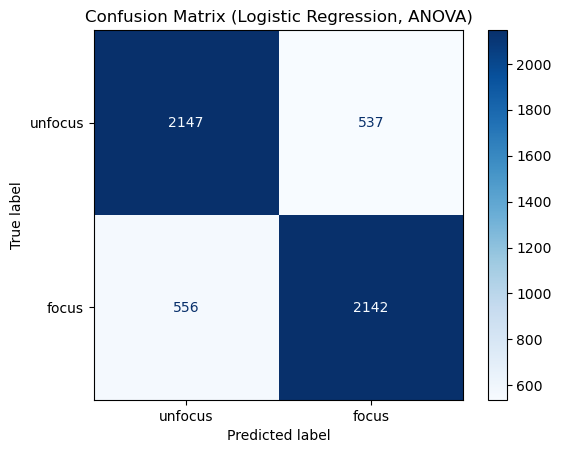

In [62]:
conf_matrix_LR_anova = confusion_matrix(y_test, y_pred_LR_anova)
dist = ConfusionMatrixDisplay(conf_matrix_LR_anova, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (Logistic Regression, ANOVA)')
plt.show()

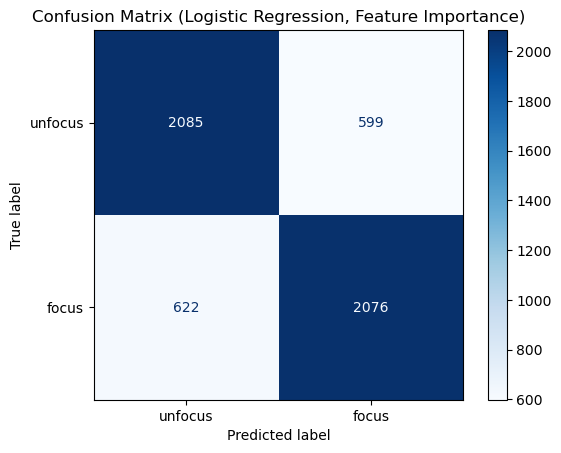

In [63]:
conf_matrix_LR_fi = confusion_matrix(y_test, y_pred_LR_fi)
dist = ConfusionMatrixDisplay(conf_matrix_LR_fi, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (Logistic Regression, Feature Importance)')
plt.show()

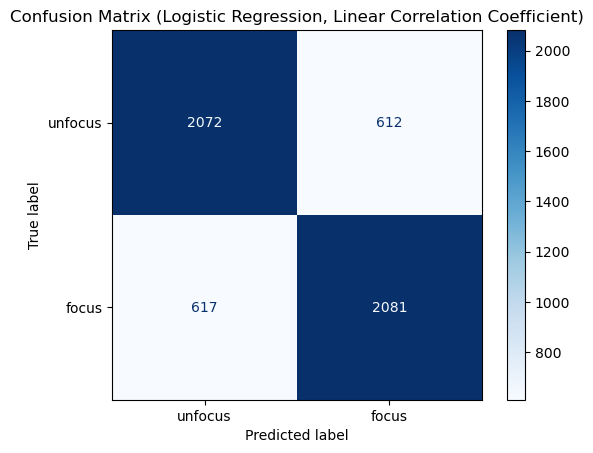

In [64]:
conf_matrix_LR_lcc = confusion_matrix(y_test, y_pred_LR_lcc)
dist = ConfusionMatrixDisplay(conf_matrix_LR_lcc, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (Logistic Regression, Linear Correlation Coefficient)')
plt.show()

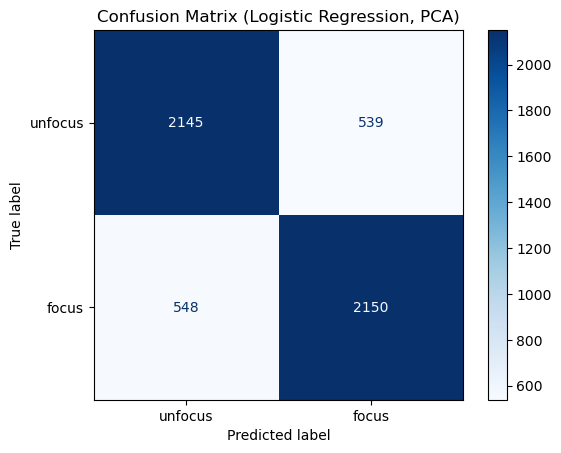

In [65]:
conf_matrix_LR_pca = confusion_matrix(y_test, y_pred_LR_pca)
dist = ConfusionMatrixDisplay(conf_matrix_LR_pca, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (Logistic Regression, PCA)')
plt.show()

### Try SVM

In [66]:
model_SVM_anova = SVC(kernel='rbf', random_state=42, probability=True)
model_SVM_fi = SVC(kernel='rbf', random_state=42, probability=True)
model_SVM_lcc = SVC(kernel='rbf', random_state=42, probability=True)
model_SVM_pca = SVC(kernel='rbf', random_state=42, probability=True)

starttime = time.time()
model_SVM_anova.fit(X_train_anova, y_train)
endtime = time.time()
training_time_SVM_anova = endtime - starttime

starttime = time.time()
model_SVM_fi.fit(X_train_fi, y_train)
endtime = time.time()
training_time_SVM_fi = endtime - starttime

starttime = time.time()
model_SVM_lcc.fit(X_train_lcc, y_train)
endtime = time.time()
training_time_SVM_lcc = endtime - starttime

starttime = time.time()
model_SVM_pca.fit(X_train_pca, y_train)
endtime = time.time()
training_time_SVM_pca = endtime - starttime

In [67]:
y_pred_SVM_anova = model_SVM_anova.predict(X_test_anova)
y_proba_SVM_anova = model_SVM_anova.predict_proba(X_test_anova)[:, 1]
acc_SVM_anova = accuracy_score(y_test, y_pred_SVM_anova)
precision_SVM_anova = precision_score(y_test, y_pred_SVM_anova, pos_label=1)
recall_SVM_anova = recall_score(y_test, y_pred_SVM_anova, pos_label=1)
f1_SVM_anova = f1_score(y_test, y_pred_SVM_anova, pos_label=1)
fpr_SVM_anova, tpr_SVM_anova, _ = roc_curve(y_test, y_proba_SVM_anova)
roc_auc_SVM_anova = auc(fpr_SVM_anova, tpr_SVM_anova)

y_pred_SVM_fi = model_SVM_fi.predict(X_test_fi)
y_proba_SVM_fi = model_SVM_fi.predict_proba(X_test_fi)[:, 1]
acc_SVM_fi = accuracy_score(y_test, y_pred_SVM_fi)
precision_SVM_fi = precision_score(y_test, y_pred_SVM_fi, pos_label=1)
recall_SVM_fi = recall_score(y_test, y_pred_SVM_fi, pos_label=1)
f1_SVM_fi = f1_score(y_test, y_pred_SVM_fi, pos_label=1)
fpr_SVM_fi, tpr_SVM_fi, _ = roc_curve(y_test, y_proba_SVM_fi)
roc_auc_SVM_fi = auc(fpr_SVM_fi, tpr_SVM_fi)

y_pred_SVM_lcc = model_SVM_lcc.predict(X_test_lcc)
y_proba_SVM_lcc = model_SVM_lcc.predict_proba(X_test_lcc)[:, 1]
acc_SVM_lcc = accuracy_score(y_test, y_pred_SVM_lcc)
precision_SVM_lcc = precision_score(y_test, y_pred_SVM_lcc, pos_label=1)
recall_SVM_lcc = recall_score(y_test, y_pred_SVM_lcc, pos_label=1)
f1_SVM_lcc = f1_score(y_test, y_pred_SVM_lcc, pos_label=1)
fpr_SVM_lcc, tpr_SVM_lcc, _ = roc_curve(y_test, y_proba_SVM_lcc)
roc_auc_SVM_lcc = auc(fpr_SVM_lcc, tpr_SVM_lcc)

y_pred_SVM_pca = model_SVM_pca.predict(X_test_pca)
y_proba_SVM_pca = model_SVM_pca.predict_proba(X_test_pca)[:, 1]
acc_SVM_pca = accuracy_score(y_test, y_pred_SVM_pca)
precision_SVM_pca = precision_score(y_test, y_pred_SVM_pca, pos_label=1)
recall_SVM_pca = recall_score(y_test, y_pred_SVM_pca, pos_label=1)
f1_SVM_pca = f1_score(y_test, y_pred_SVM_pca, pos_label=1)
fpr_SVM_pca, tpr_SVM_pca, _ = roc_curve(y_test, y_proba_SVM_pca)
roc_auc_SVM_pca = auc(fpr_SVM_pca, tpr_SVM_pca)

print('Accuracy(ANOVA):', acc_SVM_anova)
print('Accuracy(Feature Importance):', acc_SVM_fi)
print('Accuracy(Linear Correlation Coefficient):', acc_SVM_lcc)
print('Accuracy(PCA):', acc_SVM_pca)

Accuracy(ANOVA): 0.9630248978075066
Accuracy(Feature Importance): 0.9355258268301747
Accuracy(Linear Correlation Coefficient): 0.9347826086956522
Accuracy(PCA): 0.9671125975473801


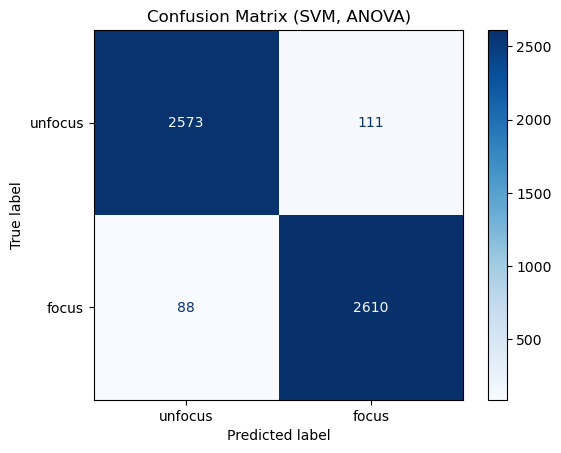

In [68]:
conf_matrix_SVM_anova = confusion_matrix(y_test, y_pred_SVM_anova)
dist = ConfusionMatrixDisplay(conf_matrix_SVM_anova, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (SVM, ANOVA)')
plt.show()

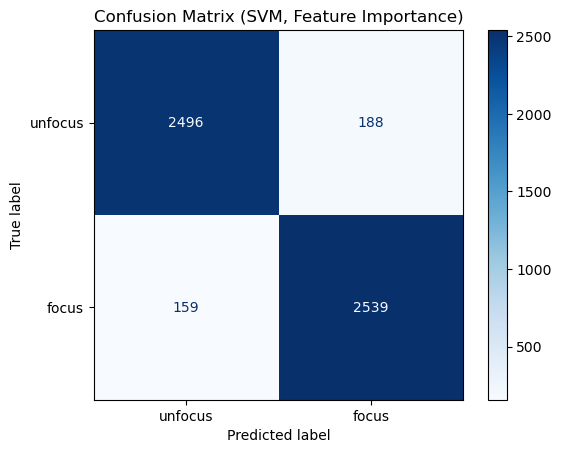

In [69]:
conf_matrix_SVM_fi = confusion_matrix(y_test, y_pred_SVM_fi)
dist = ConfusionMatrixDisplay(conf_matrix_SVM_fi, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (SVM, Feature Importance)')
plt.show()

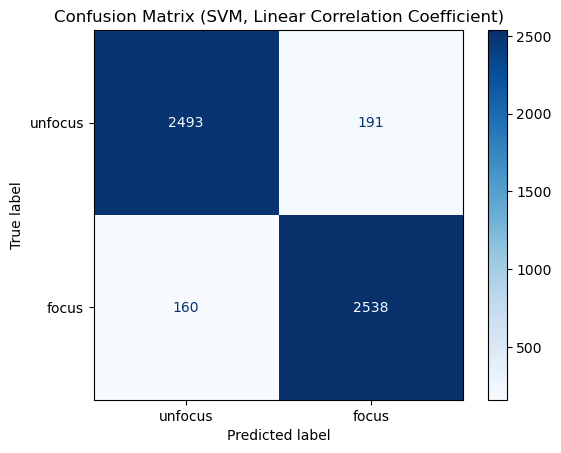

In [70]:
conf_matrix_SVM_lcc = confusion_matrix(y_test, y_pred_SVM_lcc)
dist = ConfusionMatrixDisplay(conf_matrix_SVM_lcc, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (SVM, Linear Correlation Coefficient)')
plt.show()

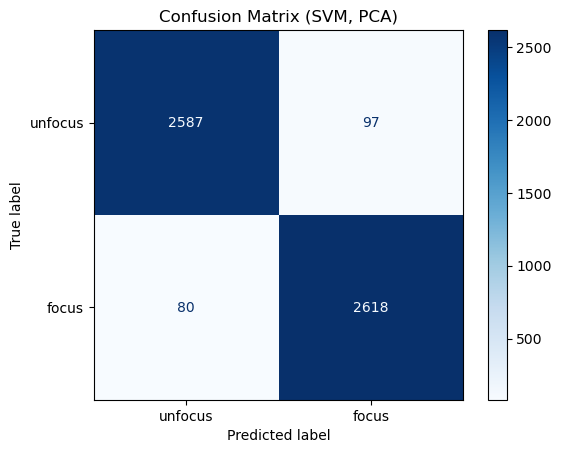

In [71]:
conf_matrix_SVM_pca = confusion_matrix(y_test, y_pred_SVM_pca)
dist = ConfusionMatrixDisplay(conf_matrix_SVM_pca, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (SVM, PCA)')
plt.show()

### Try ResNet-18

Importing Data...

Model Training:
[Epoch 1/50] -> Train Loss: 0.5328, Test Loss: 0.3415, Acc: 0.8473%
[Epoch 2/50] -> Train Loss: 0.2684, Test Loss: 0.1492, Acc: 0.9409%
[Epoch 3/50] -> Train Loss: 0.1529, Test Loss: 0.1063, Acc: 0.9606%
[Epoch 4/50] -> Train Loss: 0.0888, Test Loss: 0.0695, Acc: 0.9747%
[Epoch 5/50] -> Train Loss: 0.0619, Test Loss: 0.0862, Acc: 0.9690%
[Epoch 6/50] -> Train Loss: 0.0466, Test Loss: 0.0662, Acc: 0.9760%
[Epoch 7/50] -> Train Loss: 0.0358, Test Loss: 0.0426, Acc: 0.9844%
[Epoch 8/50] -> Train Loss: 0.0345, Test Loss: 0.0332, Acc: 0.9890%
[Epoch 9/50] -> Train Loss: 0.0345, Test Loss: 0.0288, Acc: 0.9892%
[Epoch 10/50] -> Train Loss: 0.0266, Test Loss: 0.0302, Acc: 0.9889%
[Epoch 11/50] -> Train Loss: 0.0220, Test Loss: 0.0373, Acc: 0.9870%
[Epoch 12/50] -> Train Loss: 0.0166, Test Loss: 0.0245, Acc: 0.9918%
[Epoch 13/50] -> Train Loss: 0.0214, Test Loss: 0.0263, Acc: 0.9900%
[Epoch 14/50] -> Train Loss: 0.0174, Test Loss: 0.0396, Acc: 0.9842%
[Epoch 1

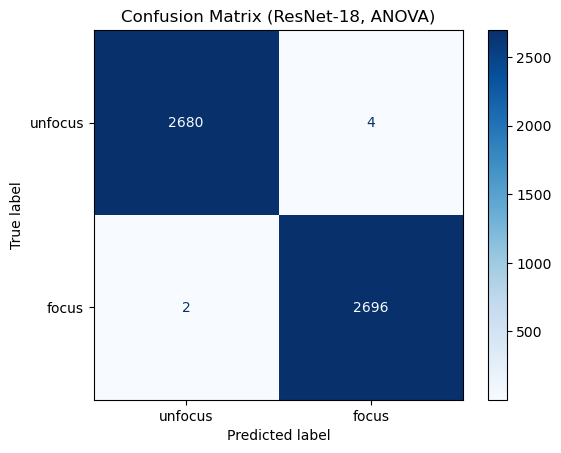

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
from torchvision.models import resnet18
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

class CustomDataset(Dataset):
    def __init__(self, X, y, transform):
        self.samples = []
        self.labels = []
        self.transform = transform
        
        for i in range(len(X)):
            sample = X[i].reshape((18, 12))
            # Reshape sample to (224, 224, 3)
            sample_resized = np.resize(sample, (224, 224))
            sample_resized = np.repeat(sample_resized[:, :, np.newaxis], 3, axis=2)
            sample_resized = sample_resized.astype(np.float32)
            sample_tensor = self.transform(sample_resized)
            
            self.samples.append(sample_tensor)
            self.labels.append(torch.tensor(y[i], dtype=torch.long))
            
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)


def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    predicted_labels = []
    true_labels = []
    predicted_proba = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            predicted_proba.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    
    cm = confusion_matrix(true_labels, predicted_labels)
    
    return running_loss / len(test_loader), accuracy, precision, recall, f1, cm, predicted_proba


batch_size = 32
learning_rate = 0.001
num_epochs = 50

train_info = pd.DataFrame(columns=['epoch', 'train_loss', 'lr', 'test_loss', 'test_acc', 'precision', 'recall', 'f1', 'time'])

torch.manual_seed(2024)
# Set GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data preprocessing transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create train and test data loaders
print("Importing Data...")
train_dataset = CustomDataset(X_train_anova.copy(), y_train.copy(), transform=transform)
test_dataset = CustomDataset(X_test_anova.copy(), y_test.copy(), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# Create model instance and move it to GPU
model = resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

best_accuracy = 0
# Model training
print("\nModel Training:")
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy, precision, recall, f1, cm, proba = test(model, test_loader, criterion, device)
    end_time = time.time()
    epoch_training_time = end_time - start_time
    train_info.loc[epoch] = [epoch + 1, train_loss, optimizer.state_dict()['param_groups'][0]['lr'], test_loss, test_accuracy, precision, recall, f1, epoch_training_time]
    scheduler.step()
    print(f'[Epoch {epoch + 1}/{num_epochs}] -> Train Loss: {train_loss:.4f}, ', end='')
    print(f'Test Loss: {test_loss:.4f}, Acc: {test_accuracy:.4f}%')
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_cm = cm
        best_proba = proba
        torch.save(model.state_dict(), './model/resnet18_model_part_detrend_plr_stft_bin_win_anova.pth')

positive_probs = [prob[1] for prob in best_proba]
negative_probs = [1 - prob[1] for prob in best_proba]
y_proba_resnet18_anova = np.column_stack((negative_probs, positive_probs))
fpr_resnet18_anova, tpr_resnet18_anova, _ = roc_curve(y_test, y_proba_resnet18_anova[:, 1])
roc_auc_resnet18_anova = auc(fpr_resnet18_anova, tpr_resnet18_anova)

train_info.to_excel('./result/train_info_resnet18_part_detrend_plr_stft_bin_win_anova.xlsx', index=False)
print(f'\nBest Accuracy: {best_accuracy:.4f}%')
dist = ConfusionMatrixDisplay(best_cm, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (ResNet-18, ANOVA)')
plt.show()

Importing Data...

Model Training:
[Epoch 1/50] -> Train Loss: 0.5489, Test Loss: 0.3831, Acc: 0.8343%
[Epoch 2/50] -> Train Loss: 0.3430, Test Loss: 0.2696, Acc: 0.8861%
[Epoch 3/50] -> Train Loss: 0.2609, Test Loss: 0.2051, Acc: 0.9173%
[Epoch 4/50] -> Train Loss: 0.1953, Test Loss: 0.2006, Acc: 0.9164%
[Epoch 5/50] -> Train Loss: 0.1667, Test Loss: 0.1370, Acc: 0.9465%
[Epoch 6/50] -> Train Loss: 0.1265, Test Loss: 0.1211, Acc: 0.9558%
[Epoch 7/50] -> Train Loss: 0.1040, Test Loss: 0.1120, Acc: 0.9565%
[Epoch 8/50] -> Train Loss: 0.0961, Test Loss: 0.0898, Acc: 0.9682%
[Epoch 9/50] -> Train Loss: 0.0815, Test Loss: 0.0956, Acc: 0.9645%
[Epoch 10/50] -> Train Loss: 0.0719, Test Loss: 0.0940, Acc: 0.9643%
[Epoch 11/50] -> Train Loss: 0.0778, Test Loss: 0.0760, Acc: 0.9721%
[Epoch 12/50] -> Train Loss: 0.0598, Test Loss: 0.0710, Acc: 0.9740%
[Epoch 13/50] -> Train Loss: 0.0925, Test Loss: 0.0713, Acc: 0.9764%
[Epoch 14/50] -> Train Loss: 0.0666, Test Loss: 0.0650, Acc: 0.9753%
[Epoch 1

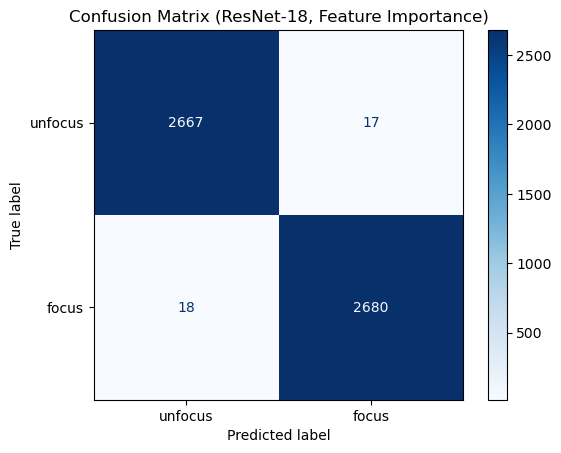

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
from torchvision.models import resnet18
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

class CustomDataset(Dataset):
    def __init__(self, X, y, transform):
        self.samples = []
        self.labels = []
        self.transform = transform
        
        for i in range(len(X)):
            sample = X[i].reshape((82, 1))
            # Reshape sample to (224, 224, 3)
            sample_resized = np.resize(sample, (224, 224))
            sample_resized = np.repeat(sample_resized[:, :, np.newaxis], 3, axis=2)
            sample_resized = sample_resized.astype(np.float32)
            sample_tensor = self.transform(sample_resized)
            
            self.samples.append(sample_tensor)
            self.labels.append(torch.tensor(y[i], dtype=torch.long))
            
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)


def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    predicted_labels = []
    true_labels = []
    predicted_proba = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            predicted_proba.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    
    cm = confusion_matrix(true_labels, predicted_labels)
    
    return running_loss / len(test_loader), accuracy, precision, recall, f1, cm, predicted_proba


batch_size = 32
learning_rate = 0.001
num_epochs = 50

train_info = pd.DataFrame(columns=['epoch', 'train_loss', 'lr', 'test_loss', 'test_acc', 'precision', 'recall', 'f1', 'time'])

torch.manual_seed(2024)
# Set GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data preprocessing transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create train and test data loaders
print("Importing Data...")
train_dataset = CustomDataset(X_train_fi.copy(), y_train.copy(), transform=transform)
test_dataset = CustomDataset(X_test_fi.copy(), y_test.copy(), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# Create model instance and move it to GPU
model = resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

best_accuracy = 0
# Model training
print("\nModel Training:")
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy, precision, recall, f1, cm, proba = test(model, test_loader, criterion, device)
    end_time = time.time()
    epoch_training_time = end_time - start_time
    train_info.loc[epoch] = [epoch + 1, train_loss, optimizer.state_dict()['param_groups'][0]['lr'], test_loss, test_accuracy, precision, recall, f1, epoch_training_time]
    scheduler.step()
    print(f'[Epoch {epoch + 1}/{num_epochs}] -> Train Loss: {train_loss:.4f}, ', end='')
    print(f'Test Loss: {test_loss:.4f}, Acc: {test_accuracy:.4f}%')
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_cm = cm
        best_proba = proba
        torch.save(model.state_dict(), './model/resnet18_model_part_detrend_plr_stft_bin_win_fi.pth')

positive_probs = [prob[1] for prob in best_proba]
negative_probs = [1 - prob[1] for prob in best_proba]
y_proba_resnet18_fi = np.column_stack((negative_probs, positive_probs))
fpr_resnet18_fi, tpr_resnet18_fi, _ = roc_curve(y_test, y_proba_resnet18_fi[:, 1])
roc_auc_resnet18_fi = auc(fpr_resnet18_fi, tpr_resnet18_fi)

train_info.to_excel('./result/train_info_resnet18_part_detrend_plr_stft_bin_win_fi.xlsx', index=False)
print(f'\nBest Accuracy: {best_accuracy:.4f}%')
dist = ConfusionMatrixDisplay(best_cm, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (ResNet-18, Feature Importance)')
plt.show()

Importing Data...

Model Training:
[Epoch 1/50] -> Train Loss: 0.5294, Test Loss: 0.4112, Acc: 0.8079%
[Epoch 2/50] -> Train Loss: 0.3174, Test Loss: 0.3061, Acc: 0.8777%
[Epoch 3/50] -> Train Loss: 0.1982, Test Loss: 0.1740, Acc: 0.9340%
[Epoch 4/50] -> Train Loss: 0.1324, Test Loss: 0.1369, Acc: 0.9459%
[Epoch 5/50] -> Train Loss: 0.1035, Test Loss: 0.1000, Acc: 0.9636%
[Epoch 6/50] -> Train Loss: 0.0794, Test Loss: 0.0961, Acc: 0.9662%
[Epoch 7/50] -> Train Loss: 0.0582, Test Loss: 0.1054, Acc: 0.9589%
[Epoch 8/50] -> Train Loss: 0.0568, Test Loss: 0.0670, Acc: 0.9779%
[Epoch 9/50] -> Train Loss: 0.0453, Test Loss: 0.0828, Acc: 0.9749%
[Epoch 10/50] -> Train Loss: 0.0405, Test Loss: 0.0455, Acc: 0.9836%
[Epoch 11/50] -> Train Loss: 0.0355, Test Loss: 0.1481, Acc: 0.9573%
[Epoch 12/50] -> Train Loss: 0.0366, Test Loss: 0.0462, Acc: 0.9827%
[Epoch 13/50] -> Train Loss: 0.0292, Test Loss: 0.0696, Acc: 0.9770%
[Epoch 14/50] -> Train Loss: 0.0301, Test Loss: 0.0756, Acc: 0.9710%
[Epoch 1

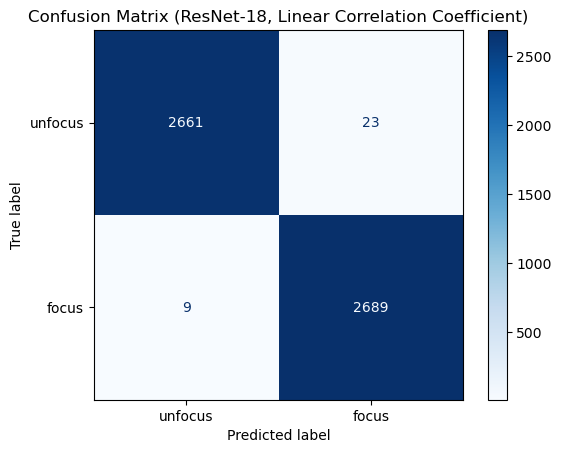

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
from torchvision.models import resnet18
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

class CustomDataset(Dataset):
    def __init__(self, X, y, transform):
        self.samples = []
        self.labels = []
        self.transform = transform
        
        for i in range(len(X)):
            sample = X[i].reshape((12, 9))
            # Reshape sample to (224, 224, 3)
            sample_resized = np.resize(sample, (224, 224))
            sample_resized = np.repeat(sample_resized[:, :, np.newaxis], 3, axis=2)
            sample_resized = sample_resized.astype(np.float32)
            sample_tensor = self.transform(sample_resized)
            
            self.samples.append(sample_tensor)
            self.labels.append(torch.tensor(y[i], dtype=torch.long))
            
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)


def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    predicted_labels = []
    true_labels = []
    predicted_proba = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            predicted_proba.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    
    cm = confusion_matrix(true_labels, predicted_labels)
    
    return running_loss / len(test_loader), accuracy, precision, recall, f1, cm, predicted_proba


batch_size = 32
learning_rate = 0.001
num_epochs = 50

train_info = pd.DataFrame(columns=['epoch', 'train_loss', 'lr', 'test_loss', 'test_acc', 'precision', 'recall', 'f1', 'time'])

torch.manual_seed(2024)
# Set GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data preprocessing transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create train and test data loaders
print("Importing Data...")
train_dataset = CustomDataset(X_train_lcc.copy(), y_train.copy(), transform=transform)
test_dataset = CustomDataset(X_test_lcc.copy(), y_test.copy(), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# Create model instance and move it to GPU
model = resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

best_accuracy = 0
# Model training
print("\nModel Training:")
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy, precision, recall, f1, cm, proba = test(model, test_loader, criterion, device)
    end_time = time.time()
    epoch_training_time = end_time - start_time
    train_info.loc[epoch] = [epoch + 1, train_loss, optimizer.state_dict()['param_groups'][0]['lr'], test_loss, test_accuracy, precision, recall, f1, epoch_training_time]
    scheduler.step()
    print(f'[Epoch {epoch + 1}/{num_epochs}] -> Train Loss: {train_loss:.4f}, ', end='')
    print(f'Test Loss: {test_loss:.4f}, Acc: {test_accuracy:.4f}%')
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_cm = cm
        best_proba = proba
        torch.save(model.state_dict(), './model/resnet18_model_part_detrend_plr_stft_bin_win_lcc.pth')

positive_probs = [prob[1] for prob in best_proba]
negative_probs = [1 - prob[1] for prob in best_proba]
y_proba_resnet18_lcc = np.column_stack((negative_probs, positive_probs))
fpr_resnet18_lcc, tpr_resnet18_lcc, _ = roc_curve(y_test, y_proba_resnet18_lcc[:, 1])
roc_auc_resnet18_lcc = auc(fpr_resnet18_lcc, tpr_resnet18_lcc)

train_info.to_excel('./result/train_info_resnet18_part_detrend_plr_stft_bin_win_lcc.xlsx', index=False)
print(f'\nBest Accuracy: {best_accuracy:.4f}%')
dist = ConfusionMatrixDisplay(best_cm, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (ResNet-18, Linear Correlation Coefficient)')
plt.show()

Importing Data...

Model Training:
[Epoch 1/50] -> Train Loss: 0.4511, Test Loss: 0.4681, Acc: 0.8010%
[Epoch 2/50] -> Train Loss: 0.2144, Test Loss: 0.1345, Acc: 0.9534%
[Epoch 3/50] -> Train Loss: 0.1205, Test Loss: 0.0822, Acc: 0.9701%
[Epoch 4/50] -> Train Loss: 0.0762, Test Loss: 0.0836, Acc: 0.9660%
[Epoch 5/50] -> Train Loss: 0.0580, Test Loss: 0.0471, Acc: 0.9835%
[Epoch 6/50] -> Train Loss: 0.0418, Test Loss: 0.0557, Acc: 0.9844%
[Epoch 7/50] -> Train Loss: 0.0379, Test Loss: 0.0674, Acc: 0.9799%
[Epoch 8/50] -> Train Loss: 0.0342, Test Loss: 0.0519, Acc: 0.9805%
[Epoch 9/50] -> Train Loss: 0.0245, Test Loss: 0.0885, Acc: 0.9705%
[Epoch 10/50] -> Train Loss: 0.0266, Test Loss: 0.0651, Acc: 0.9745%
[Epoch 11/50] -> Train Loss: 0.0258, Test Loss: 0.0492, Acc: 0.9842%
[Epoch 12/50] -> Train Loss: 0.0205, Test Loss: 0.0232, Acc: 0.9922%
[Epoch 13/50] -> Train Loss: 0.0198, Test Loss: 0.0183, Acc: 0.9948%
[Epoch 14/50] -> Train Loss: 0.0209, Test Loss: 0.0613, Acc: 0.9820%
[Epoch 1

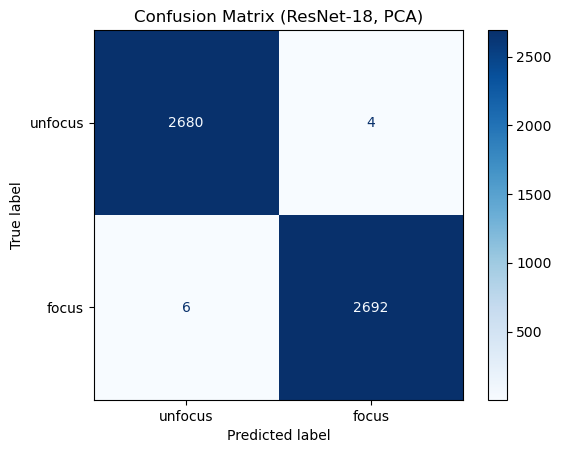

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
from torchvision.models import resnet18
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

class CustomDataset(Dataset):
    def __init__(self, X, y, transform):
        self.samples = []
        self.labels = []
        self.transform = transform
        
        for i in range(len(X)):
            sample = X[i].reshape((251, 1))
            # Reshape sample to (224, 224, 3)
            sample_resized = np.resize(sample, (224, 224))
            sample_resized = np.repeat(sample_resized[:, :, np.newaxis], 3, axis=2)
            sample_resized = sample_resized.astype(np.float32)
            sample_tensor = self.transform(sample_resized)
            
            self.samples.append(sample_tensor)
            self.labels.append(torch.tensor(y[i], dtype=torch.long))
            
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)


def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    predicted_labels = []
    true_labels = []
    predicted_proba = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            predicted_proba.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    
    cm = confusion_matrix(true_labels, predicted_labels)
    
    return running_loss / len(test_loader), accuracy, precision, recall, f1, cm, predicted_proba


batch_size = 32
learning_rate = 0.001
num_epochs = 50

train_info = pd.DataFrame(columns=['epoch', 'train_loss', 'lr', 'test_loss', 'test_acc', 'precision', 'recall', 'f1', 'time'])

torch.manual_seed(2024)
# Set GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data preprocessing transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create train and test data loaders
print("Importing Data...")
train_dataset = CustomDataset(X_train_pca.copy(), y_train.copy(), transform=transform)
test_dataset = CustomDataset(X_test_pca.copy(), y_test.copy(), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# Create model instance and move it to GPU
model = resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

best_accuracy = 0
# Model training
print("\nModel Training:")
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy, precision, recall, f1, cm, proba = test(model, test_loader, criterion, device)
    end_time = time.time()
    epoch_training_time = end_time - start_time
    train_info.loc[epoch] = [epoch + 1, train_loss, optimizer.state_dict()['param_groups'][0]['lr'], test_loss, test_accuracy, precision, recall, f1, epoch_training_time]
    scheduler.step()
    print(f'[Epoch {epoch + 1}/{num_epochs}] -> Train Loss: {train_loss:.4f}, ', end='')
    print(f'Test Loss: {test_loss:.4f}, Acc: {test_accuracy:.4f}%')
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_cm = cm
        best_proba = proba
        torch.save(model.state_dict(), './model/resnet18_model_part_detrend_plr_stft_bin_win_pca.pth')

positive_probs = [prob[1] for prob in best_proba]
negative_probs = [1 - prob[1] for prob in best_proba]
y_proba_resnet18_pca = np.column_stack((negative_probs, positive_probs))
fpr_resnet18_pca, tpr_resnet18_pca, _ = roc_curve(y_test, y_proba_resnet18_pca[:, 1])
roc_auc_resnet18_pca = auc(fpr_resnet18_pca, tpr_resnet18_pca)

train_info.to_excel('./result/train_info_resnet18_part_detrend_plr_stft_bin_win_pca.xlsx', index=False)
print(f'\nBest Accuracy: {best_accuracy:.4f}%')
dist = ConfusionMatrixDisplay(best_cm, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (ResNet-18, PCA)')
plt.show()

### Try GoogLeNet

Importing Data...

Model Training:
[Epoch 1/50] -> Train Loss: 0.3478, Test Loss: 0.2055, Acc: 0.9246%
[Epoch 2/50] -> Train Loss: 0.1144, Test Loss: 0.0526, Acc: 0.9809%
[Epoch 3/50] -> Train Loss: 0.0532, Test Loss: 0.0527, Acc: 0.9816%
[Epoch 4/50] -> Train Loss: 0.0428, Test Loss: 0.0552, Acc: 0.9770%
[Epoch 5/50] -> Train Loss: 0.0300, Test Loss: 0.0392, Acc: 0.9866%
[Epoch 6/50] -> Train Loss: 0.0260, Test Loss: 0.0204, Acc: 0.9946%
[Epoch 7/50] -> Train Loss: 0.0228, Test Loss: 0.0320, Acc: 0.9870%
[Epoch 8/50] -> Train Loss: 0.0242, Test Loss: 0.0451, Acc: 0.9859%
[Epoch 9/50] -> Train Loss: 0.0212, Test Loss: 0.0287, Acc: 0.9911%
[Epoch 10/50] -> Train Loss: 0.0182, Test Loss: 0.0164, Acc: 0.9957%
[Epoch 11/50] -> Train Loss: 0.0132, Test Loss: 0.0184, Acc: 0.9939%
[Epoch 12/50] -> Train Loss: 0.0180, Test Loss: 0.0291, Acc: 0.9887%
[Epoch 13/50] -> Train Loss: 0.0144, Test Loss: 0.0316, Acc: 0.9903%
[Epoch 14/50] -> Train Loss: 0.0145, Test Loss: 0.0142, Acc: 0.9950%
[Epoch 1

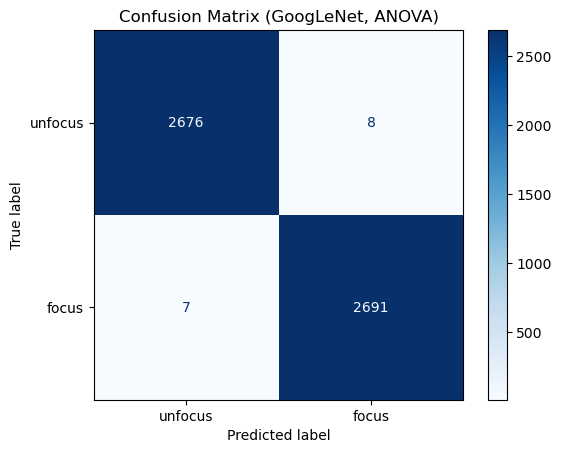

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
from torchvision.models import googlenet
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

class CustomDataset(Dataset):
    def __init__(self, X, y, transform):
        self.samples = []
        self.labels = []
        self.transform = transform
        
        for i in range(len(X)):
            sample = X[i].reshape((18, 12))
            # Reshape sample to (224, 224, 3)
            sample_resized = np.resize(sample, (224, 224))
            sample_resized = np.repeat(sample_resized[:, :, np.newaxis], 3, axis=2)
            sample_resized = sample_resized.astype(np.float32)
            sample_tensor = self.transform(sample_resized)
            
            self.samples.append(sample_tensor)
            self.labels.append(torch.tensor(y[i], dtype=torch.long))
            
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)


def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    predicted_labels = []
    true_labels = []
    predicted_proba = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            predicted_proba.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    
    cm = confusion_matrix(true_labels, predicted_labels)
    
    return running_loss / len(test_loader), accuracy, precision, recall, f1, cm, predicted_proba


batch_size = 32
learning_rate = 0.001
num_epochs = 50

train_info = pd.DataFrame(columns=['epoch', 'train_loss', 'lr', 'test_loss', 'test_acc', 'precision', 'recall', 'f1', 'time'])

torch.manual_seed(2024)
# Set GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data preprocessing transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create train and test data loaders
print("Importing Data...")
train_dataset = CustomDataset(X_train_anova.copy(), y_train.copy(), transform=transform)
test_dataset = CustomDataset(X_test_anova.copy(), y_test.copy(), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# Create model instance and move it to GPU
model = googlenet(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
# Remove the last pooling layer
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

best_accuracy = 0
# Model training
print("\nModel Training:")
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy, precision, recall, f1, cm, proba = test(model, test_loader, criterion, device)
    end_time = time.time()
    epoch_training_time = end_time - start_time
    train_info.loc[epoch] = [epoch + 1, train_loss, optimizer.state_dict()['param_groups'][0]['lr'], test_loss, test_accuracy, precision, recall, f1, epoch_training_time]
    scheduler.step()
    print(f'[Epoch {epoch + 1}/{num_epochs}] -> Train Loss: {train_loss:.4f}, ', end='')
    print(f'Test Loss: {test_loss:.4f}, Acc: {test_accuracy:.4f}%')
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_cm = cm
        best_proba = proba
        torch.save(model.state_dict(), './model/googlenet_model_part_detrend_plr_stft_bin_win_anova.pth')

positive_probs = [prob[1] for prob in best_proba]
negative_probs = [1 - prob[1] for prob in best_proba]
y_proba_googlenet_anova = np.column_stack((negative_probs, positive_probs))
fpr_googlenet_anova, tpr_googlenet_anova, _ = roc_curve(y_test, y_proba_googlenet_anova[:, 1])
roc_auc_googlenet_anova = auc(fpr_googlenet_anova, tpr_googlenet_anova)

train_info.to_excel('./result/train_info_googlenet_part_detrend_plr_stft_bin_win_anova.xlsx', index=False)
print(f'\nBest Accuracy: {best_accuracy:.4f}%')
dist = ConfusionMatrixDisplay(best_cm, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (GoogLeNet, ANOVA)')
plt.show()

Importing Data...

Model Training:
[Epoch 1/50] -> Train Loss: 0.3817, Test Loss: 0.1976, Acc: 0.9227%
[Epoch 2/50] -> Train Loss: 0.1568, Test Loss: 0.1265, Acc: 0.9511%
[Epoch 3/50] -> Train Loss: 0.0852, Test Loss: 0.0948, Acc: 0.9662%
[Epoch 4/50] -> Train Loss: 0.0620, Test Loss: 0.0637, Acc: 0.9784%
[Epoch 5/50] -> Train Loss: 0.0510, Test Loss: 0.0675, Acc: 0.9781%
[Epoch 6/50] -> Train Loss: 0.0334, Test Loss: 0.0351, Acc: 0.9881%
[Epoch 7/50] -> Train Loss: 0.0273, Test Loss: 0.0439, Acc: 0.9851%
[Epoch 8/50] -> Train Loss: 0.0270, Test Loss: 0.0368, Acc: 0.9889%
[Epoch 9/50] -> Train Loss: 0.0220, Test Loss: 0.0444, Acc: 0.9844%
[Epoch 10/50] -> Train Loss: 0.0259, Test Loss: 0.0324, Acc: 0.9887%
[Epoch 11/50] -> Train Loss: 0.0194, Test Loss: 0.0436, Acc: 0.9872%
[Epoch 12/50] -> Train Loss: 0.0179, Test Loss: 0.0371, Acc: 0.9881%
[Epoch 13/50] -> Train Loss: 0.0194, Test Loss: 0.0331, Acc: 0.9903%
[Epoch 14/50] -> Train Loss: 0.0171, Test Loss: 0.0212, Acc: 0.9948%
[Epoch 1

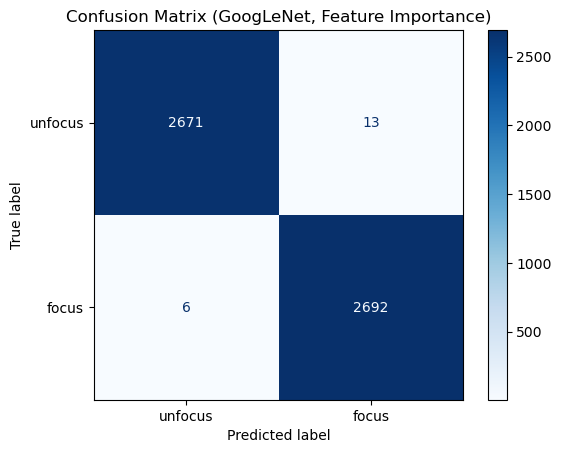

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
from torchvision.models import googlenet
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

class CustomDataset(Dataset):
    def __init__(self, X, y, transform):
        self.samples = []
        self.labels = []
        self.transform = transform
        
        for i in range(len(X)):
            sample = X[i].reshape((82, 1))
            # Reshape sample to (224, 224, 3)
            sample_resized = np.resize(sample, (224, 224))
            sample_resized = np.repeat(sample_resized[:, :, np.newaxis], 3, axis=2)
            sample_resized = sample_resized.astype(np.float32)
            sample_tensor = self.transform(sample_resized)
            
            self.samples.append(sample_tensor)
            self.labels.append(torch.tensor(y[i], dtype=torch.long))
            
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)


def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    predicted_labels = []
    true_labels = []
    predicted_proba = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            predicted_proba.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    
    cm = confusion_matrix(true_labels, predicted_labels)
    
    return running_loss / len(test_loader), accuracy, precision, recall, f1, cm, predicted_proba


batch_size = 32
learning_rate = 0.001
num_epochs = 50

train_info = pd.DataFrame(columns=['epoch', 'train_loss', 'lr', 'test_loss', 'test_acc', 'precision', 'recall', 'f1', 'time'])

torch.manual_seed(2024)
# Set GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data preprocessing transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create train and test data loaders
print("Importing Data...")
train_dataset = CustomDataset(X_train_fi.copy(), y_train.copy(), transform=transform)
test_dataset = CustomDataset(X_test_fi.copy(), y_test.copy(), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# Create model instance and move it to GPU
model = googlenet(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
# Remove the last pooling layer
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

best_accuracy = 0
# Model training
print("\nModel Training:")
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy, precision, recall, f1, cm, proba = test(model, test_loader, criterion, device)
    end_time = time.time()
    epoch_training_time = end_time - start_time
    train_info.loc[epoch] = [epoch + 1, train_loss, optimizer.state_dict()['param_groups'][0]['lr'], test_loss, test_accuracy, precision, recall, f1, epoch_training_time]
    scheduler.step()
    print(f'[Epoch {epoch + 1}/{num_epochs}] -> Train Loss: {train_loss:.4f}, ', end='')
    print(f'Test Loss: {test_loss:.4f}, Acc: {test_accuracy:.4f}%')
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_cm = cm
        best_proba = proba
        torch.save(model.state_dict(), './model/googlenet_model_part_detrend_plr_stft_bin_win_fi.pth')

positive_probs = [prob[1] for prob in best_proba]
negative_probs = [1 - prob[1] for prob in best_proba]
y_proba_googlenet_fi = np.column_stack((negative_probs, positive_probs))
fpr_googlenet_fi, tpr_googlenet_fi, _ = roc_curve(y_test, y_proba_googlenet_fi[:, 1])
roc_auc_googlenet_fi = auc(fpr_googlenet_fi, tpr_googlenet_fi)

train_info.to_excel('./result/train_info_googlenet_part_detrend_plr_stft_bin_win_fi.xlsx', index=False)
print(f'\nBest Accuracy: {best_accuracy:.4f}%')
dist = ConfusionMatrixDisplay(best_cm, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (GoogLeNet, Feature Importance)')
plt.show()

Importing Data...

Model Training:
[Epoch 1/50] -> Train Loss: 0.4229, Test Loss: 0.3085, Acc: 0.8647%
[Epoch 2/50] -> Train Loss: 0.2062, Test Loss: 0.1403, Acc: 0.9465%
[Epoch 3/50] -> Train Loss: 0.1038, Test Loss: 0.0715, Acc: 0.9738%
[Epoch 4/50] -> Train Loss: 0.0674, Test Loss: 0.0520, Acc: 0.9820%
[Epoch 5/50] -> Train Loss: 0.0483, Test Loss: 0.0460, Acc: 0.9849%
[Epoch 6/50] -> Train Loss: 0.0350, Test Loss: 0.0658, Acc: 0.9797%
[Epoch 7/50] -> Train Loss: 0.0351, Test Loss: 0.0429, Acc: 0.9863%
[Epoch 8/50] -> Train Loss: 0.0270, Test Loss: 0.0663, Acc: 0.9803%
[Epoch 9/50] -> Train Loss: 0.0266, Test Loss: 0.0436, Acc: 0.9851%
[Epoch 10/50] -> Train Loss: 0.0283, Test Loss: 0.0413, Acc: 0.9870%
[Epoch 11/50] -> Train Loss: 0.0173, Test Loss: 0.0822, Acc: 0.9757%
[Epoch 12/50] -> Train Loss: 0.0178, Test Loss: 0.0375, Acc: 0.9868%
[Epoch 13/50] -> Train Loss: 0.0184, Test Loss: 0.0336, Acc: 0.9889%
[Epoch 14/50] -> Train Loss: 0.0185, Test Loss: 0.0360, Acc: 0.9892%
[Epoch 1

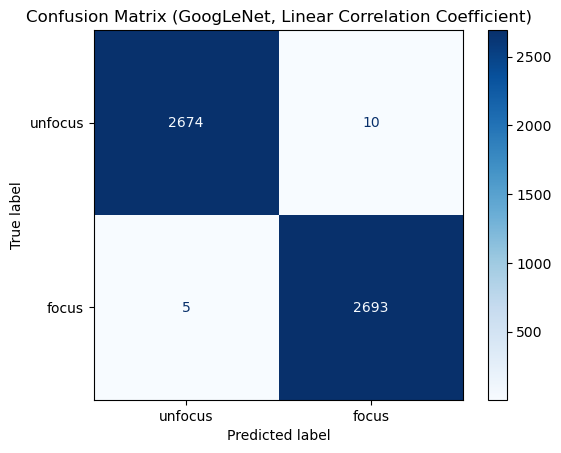

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
from torchvision.models import googlenet
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

class CustomDataset(Dataset):
    def __init__(self, X, y, transform):
        self.samples = []
        self.labels = []
        self.transform = transform
        
        for i in range(len(X)):
            sample = X[i].reshape((12, 9))
            # Reshape sample to (224, 224, 3)
            sample_resized = np.resize(sample, (224, 224))
            sample_resized = np.repeat(sample_resized[:, :, np.newaxis], 3, axis=2)
            sample_resized = sample_resized.astype(np.float32)
            sample_tensor = self.transform(sample_resized)
            
            self.samples.append(sample_tensor)
            self.labels.append(torch.tensor(y[i], dtype=torch.long))
            
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)


def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    predicted_labels = []
    true_labels = []
    predicted_proba = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            predicted_proba.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    
    cm = confusion_matrix(true_labels, predicted_labels)
    
    return running_loss / len(test_loader), accuracy, precision, recall, f1, cm, predicted_proba


batch_size = 32
learning_rate = 0.001
num_epochs = 50

train_info = pd.DataFrame(columns=['epoch', 'train_loss', 'lr', 'test_loss', 'test_acc', 'precision', 'recall', 'f1', 'time'])

torch.manual_seed(2024)
# Set GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data preprocessing transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create train and test data loaders
print("Importing Data...")
train_dataset = CustomDataset(X_train_lcc.copy(), y_train.copy(), transform=transform)
test_dataset = CustomDataset(X_test_lcc.copy(), y_test.copy(), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# Create model instance and move it to GPU
model = googlenet(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
# Remove the last pooling layer
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

best_accuracy = 0
# Model training
print("\nModel Training:")
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy, precision, recall, f1, cm, proba = test(model, test_loader, criterion, device)
    end_time = time.time()
    epoch_training_time = end_time - start_time
    train_info.loc[epoch] = [epoch + 1, train_loss, optimizer.state_dict()['param_groups'][0]['lr'], test_loss, test_accuracy, precision, recall, f1, epoch_training_time]
    scheduler.step()
    print(f'[Epoch {epoch + 1}/{num_epochs}] -> Train Loss: {train_loss:.4f}, ', end='')
    print(f'Test Loss: {test_loss:.4f}, Acc: {test_accuracy:.4f}%')
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_cm = cm
        best_proba = proba
        torch.save(model.state_dict(), './model/googlenet_model_part_detrend_plr_stft_bin_win_lcc.pth')

positive_probs = [prob[1] for prob in best_proba]
negative_probs = [1 - prob[1] for prob in best_proba]
y_proba_googlenet_lcc = np.column_stack((negative_probs, positive_probs))
fpr_googlenet_lcc, tpr_googlenet_lcc, _ = roc_curve(y_test, y_proba_googlenet_lcc[:, 1])
roc_auc_googlenet_lcc = auc(fpr_googlenet_lcc, tpr_googlenet_lcc)

train_info.to_excel('./result/train_info_googlenet_part_detrend_plr_stft_bin_win_lcc.xlsx', index=False)
print(f'\nBest Accuracy: {best_accuracy:.4f}%')
dist = ConfusionMatrixDisplay(best_cm, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (GoogLeNet, Linear Correlation Coefficient)')
plt.show()

Importing Data...

Model Training:
[Epoch 1/50] -> Train Loss: 0.3646, Test Loss: 0.1528, Acc: 0.9439%
[Epoch 2/50] -> Train Loss: 0.1309, Test Loss: 0.0917, Acc: 0.9666%
[Epoch 3/50] -> Train Loss: 0.0642, Test Loss: 0.0565, Acc: 0.9805%
[Epoch 4/50] -> Train Loss: 0.0479, Test Loss: 0.0326, Acc: 0.9896%
[Epoch 5/50] -> Train Loss: 0.0412, Test Loss: 0.0544, Acc: 0.9814%
[Epoch 6/50] -> Train Loss: 0.0289, Test Loss: 0.0382, Acc: 0.9876%
[Epoch 7/50] -> Train Loss: 0.0315, Test Loss: 0.0454, Acc: 0.9849%
[Epoch 8/50] -> Train Loss: 0.0216, Test Loss: 0.0616, Acc: 0.9775%
[Epoch 9/50] -> Train Loss: 0.0249, Test Loss: 0.0596, Acc: 0.9823%
[Epoch 10/50] -> Train Loss: 0.0174, Test Loss: 0.0498, Acc: 0.9861%
[Epoch 11/50] -> Train Loss: 0.0208, Test Loss: 0.0618, Acc: 0.9825%
[Epoch 12/50] -> Train Loss: 0.0199, Test Loss: 0.0397, Acc: 0.9890%
[Epoch 13/50] -> Train Loss: 0.0195, Test Loss: 0.0372, Acc: 0.9898%
[Epoch 14/50] -> Train Loss: 0.0152, Test Loss: 0.0347, Acc: 0.9907%
[Epoch 1

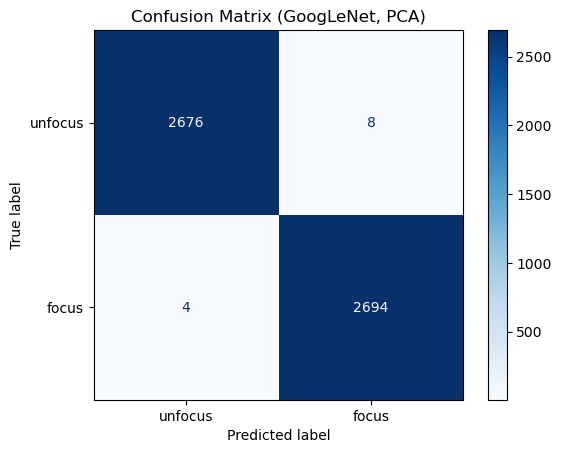

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
from torchvision.models import googlenet
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

class CustomDataset(Dataset):
    def __init__(self, X, y, transform):
        self.samples = []
        self.labels = []
        self.transform = transform
        
        for i in range(len(X)):
            sample = X[i].reshape((251, 1))
            # Reshape sample to (224, 224, 3)
            sample_resized = np.resize(sample, (224, 224))
            sample_resized = np.repeat(sample_resized[:, :, np.newaxis], 3, axis=2)
            sample_resized = sample_resized.astype(np.float32)
            sample_tensor = self.transform(sample_resized)
            
            self.samples.append(sample_tensor)
            self.labels.append(torch.tensor(y[i], dtype=torch.long))
            
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)


def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    predicted_labels = []
    true_labels = []
    predicted_proba = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            predicted_proba.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    
    cm = confusion_matrix(true_labels, predicted_labels)
    
    return running_loss / len(test_loader), accuracy, precision, recall, f1, cm, predicted_proba


batch_size = 32
learning_rate = 0.001
num_epochs = 50

train_info = pd.DataFrame(columns=['epoch', 'train_loss', 'lr', 'test_loss', 'test_acc', 'precision', 'recall', 'f1', 'time'])

torch.manual_seed(2024)
# Set GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data preprocessing transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create train and test data loaders
print("Importing Data...")
train_dataset = CustomDataset(X_train_pca.copy(), y_train.copy(), transform=transform)
test_dataset = CustomDataset(X_test_pca.copy(), y_test.copy(), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# Create model instance and move it to GPU
model = googlenet(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
# Remove the last pooling layer
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

best_accuracy = 0
# Model training
print("\nModel Training:")
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy, precision, recall, f1, cm, proba = test(model, test_loader, criterion, device)
    end_time = time.time()
    epoch_training_time = end_time - start_time
    train_info.loc[epoch] = [epoch + 1, train_loss, optimizer.state_dict()['param_groups'][0]['lr'], test_loss, test_accuracy, precision, recall, f1, epoch_training_time]
    scheduler.step()
    print(f'[Epoch {epoch + 1}/{num_epochs}] -> Train Loss: {train_loss:.4f}, ', end='')
    print(f'Test Loss: {test_loss:.4f}, Acc: {test_accuracy:.4f}%')
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_cm = cm
        best_proba = proba
        torch.save(model.state_dict(), './model/googlenet_model_part_detrend_plr_stft_bin_win_pca.pth')

positive_probs = [prob[1] for prob in best_proba]
negative_probs = [1 - prob[1] for prob in best_proba]
y_proba_googlenet_pca = np.column_stack((negative_probs, positive_probs))
fpr_googlenet_pca, tpr_googlenet_pca, _ = roc_curve(y_test, y_proba_googlenet_pca[:, 1])
roc_auc_googlenet_pca = auc(fpr_googlenet_pca, tpr_googlenet_pca)

train_info.to_excel('./result/train_info_googlenet_part_detrend_plr_stft_bin_win_pca.xlsx', index=False)
print(f'\nBest Accuracy: {best_accuracy:.4f}%')
dist = ConfusionMatrixDisplay(best_cm, display_labels=['unfocus', 'focus'])
dist.plot(cmap='Blues')
plt.title('Confusion Matrix (GoogLeNet, PCA)')
plt.show()

### Draw ROC images

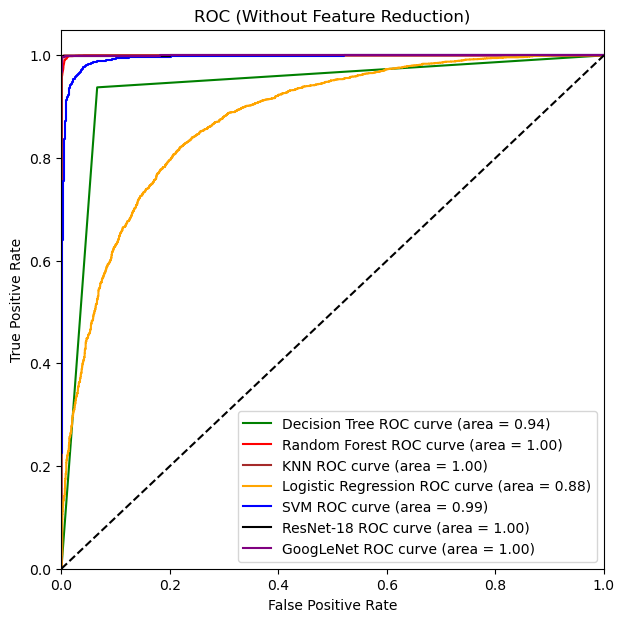

In [96]:
plt.figure(figsize=(7,7))

plt.plot(fpr_DT, tpr_DT, label='Decision Tree ROC curve (area = %0.2f)' % roc_auc_DT, color='green')
plt.plot(fpr_RF, tpr_RF, label='Random Forest ROC curve (area = %0.2f)' % roc_auc_RF, color='red')
plt.plot(fpr_KNN, tpr_KNN, label='KNN ROC curve (area = %0.2f)' % roc_auc_KNN, color='brown')
plt.plot(fpr_LR, tpr_LR, label='Logistic Regression ROC curve (area = %0.2f)' % roc_auc_LR, color='orange')
plt.plot(fpr_SVM, tpr_SVM, label='SVM ROC curve (area = %0.2f)' % roc_auc_SVM, color='blue')
plt.plot(fpr_resnet18, tpr_resnet18, label='ResNet-18 ROC curve (area = %0.2f)' % roc_auc_resnet18, color='black')
plt.plot(fpr_googlenet, tpr_googlenet, label='GoogLeNet ROC curve (area = %0.2f)' % roc_auc_googlenet, color='purple')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Without Feature Reduction)')
plt.legend(loc="lower right")
plt.show()

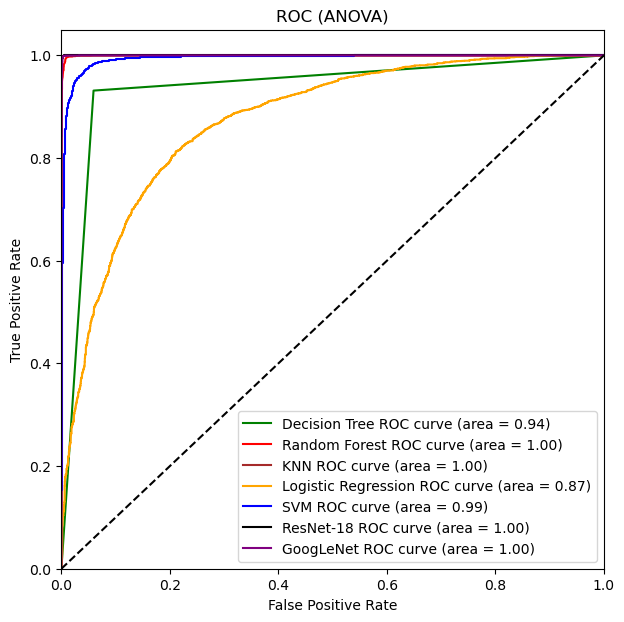

In [97]:
plt.figure(figsize=(7,7))

plt.plot(fpr_DT_anova, tpr_DT_anova, label='Decision Tree ROC curve (area = %0.2f)' % roc_auc_DT_anova, color='green')
plt.plot(fpr_RF_anova, tpr_RF_anova, label='Random Forest ROC curve (area = %0.2f)' % roc_auc_RF_anova, color='red')
plt.plot(fpr_KNN_anova, tpr_KNN_anova, label='KNN ROC curve (area = %0.2f)' % roc_auc_KNN_anova, color='brown')
plt.plot(fpr_LR_anova, tpr_LR_anova, label='Logistic Regression ROC curve (area = %0.2f)' % roc_auc_LR_anova, color='orange')
plt.plot(fpr_SVM_anova, tpr_SVM_anova, label='SVM ROC curve (area = %0.2f)' % roc_auc_SVM_anova, color='blue')
plt.plot(fpr_resnet18_anova, tpr_resnet18_anova, label='ResNet-18 ROC curve (area = %0.2f)' % roc_auc_resnet18_anova, color='black')
plt.plot(fpr_googlenet_anova, tpr_googlenet_anova, label='GoogLeNet ROC curve (area = %0.2f)' % roc_auc_googlenet_anova, color='purple')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (ANOVA)')
plt.legend(loc="lower right")
plt.show()

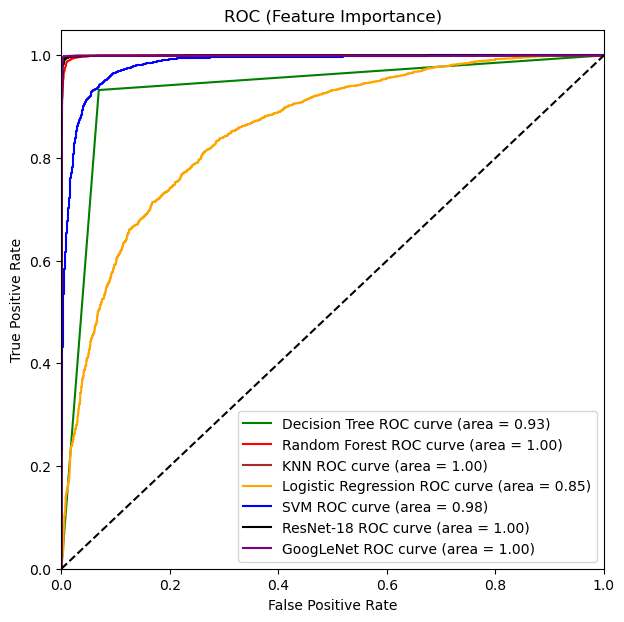

In [98]:
plt.figure(figsize=(7,7))

plt.plot(fpr_DT_fi, tpr_DT_fi, label='Decision Tree ROC curve (area = %0.2f)' % roc_auc_DT_fi, color='green')
plt.plot(fpr_RF_fi, tpr_RF_fi, label='Random Forest ROC curve (area = %0.2f)' % roc_auc_RF_fi, color='red')
plt.plot(fpr_KNN_fi, tpr_KNN_fi, label='KNN ROC curve (area = %0.2f)' % roc_auc_KNN_fi, color='brown')
plt.plot(fpr_LR_fi, tpr_LR_fi, label='Logistic Regression ROC curve (area = %0.2f)' % roc_auc_LR_fi, color='orange')
plt.plot(fpr_SVM_fi, tpr_SVM_fi, label='SVM ROC curve (area = %0.2f)' % roc_auc_SVM_fi, color='blue')
plt.plot(fpr_resnet18_fi, tpr_resnet18_fi, label='ResNet-18 ROC curve (area = %0.2f)' % roc_auc_resnet18_fi, color='black')
plt.plot(fpr_googlenet_fi, tpr_googlenet_fi, label='GoogLeNet ROC curve (area = %0.2f)' % roc_auc_googlenet_fi, color='purple')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Feature Importance)')
plt.legend(loc="lower right")
plt.show()

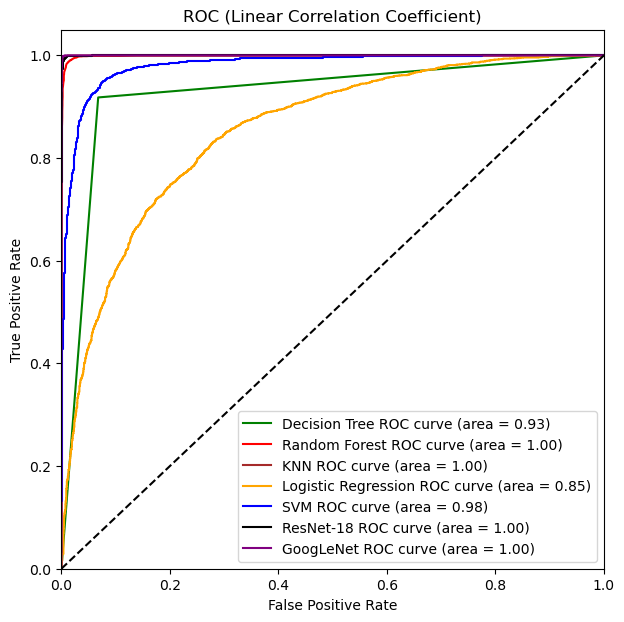

In [99]:
plt.figure(figsize=(7,7))

plt.plot(fpr_DT_lcc, tpr_DT_lcc, label='Decision Tree ROC curve (area = %0.2f)' % roc_auc_DT_lcc, color='green')
plt.plot(fpr_RF_lcc, tpr_RF_lcc, label='Random Forest ROC curve (area = %0.2f)' % roc_auc_RF_lcc, color='red')
plt.plot(fpr_KNN_lcc, tpr_KNN_lcc, label='KNN ROC curve (area = %0.2f)' % roc_auc_KNN_lcc, color='brown')
plt.plot(fpr_LR_lcc, tpr_LR_lcc, label='Logistic Regression ROC curve (area = %0.2f)' % roc_auc_LR_lcc, color='orange')
plt.plot(fpr_SVM_lcc, tpr_SVM_lcc, label='SVM ROC curve (area = %0.2f)' % roc_auc_SVM_lcc, color='blue')
plt.plot(fpr_resnet18_lcc, tpr_resnet18_lcc, label='ResNet-18 ROC curve (area = %0.2f)' % roc_auc_resnet18_lcc, color='black')
plt.plot(fpr_googlenet_lcc, tpr_googlenet_lcc, label='GoogLeNet ROC curve (area = %0.2f)' % roc_auc_googlenet_lcc, color='purple')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Linear Correlation Coefficient)')
plt.legend(loc="lower right")
plt.show()

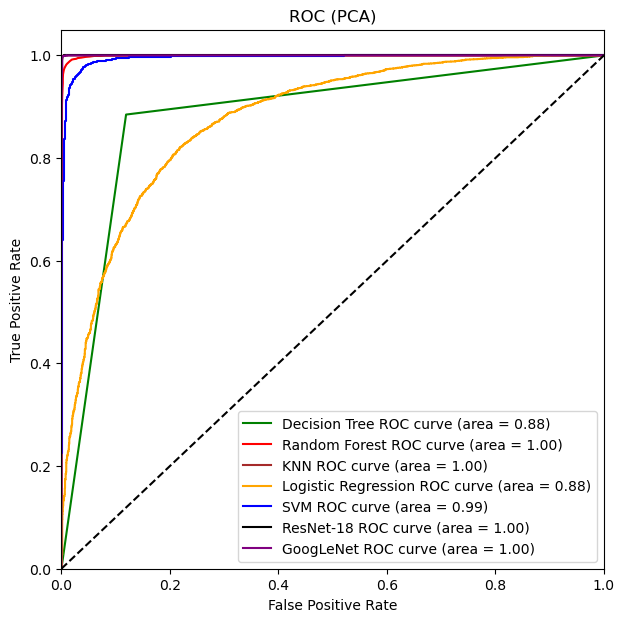

In [100]:
plt.figure(figsize=(7,7))

plt.plot(fpr_DT_pca, tpr_DT_pca, label='Decision Tree ROC curve (area = %0.2f)' % roc_auc_DT_pca, color='green')
plt.plot(fpr_RF_pca, tpr_RF_pca, label='Random Forest ROC curve (area = %0.2f)' % roc_auc_RF_pca, color='red')
plt.plot(fpr_KNN_pca, tpr_KNN_pca, label='KNN ROC curve (area = %0.2f)' % roc_auc_KNN_pca, color='brown')
plt.plot(fpr_LR_pca, tpr_LR_pca, label='Logistic Regression ROC curve (area = %0.2f)' % roc_auc_LR_pca, color='orange')
plt.plot(fpr_SVM_pca, tpr_SVM_pca, label='SVM ROC curve (area = %0.2f)' % roc_auc_SVM_pca, color='blue')
plt.plot(fpr_resnet18_pca, tpr_resnet18_pca, label='ResNet-18 ROC curve (area = %0.2f)' % roc_auc_resnet18_pca, color='black')
plt.plot(fpr_googlenet_pca, tpr_googlenet_pca, label='GoogLeNet ROC curve (area = %0.2f)' % roc_auc_googlenet_pca, color='purple')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (PCA)')
plt.legend(loc="lower right")
plt.show()

### Save training results (Classic Models)

In [ ]:
result_group = pd.DataFrame(columns=['model', 'time', 'precision', 'recall', 'f1', 'test_acc'])
result_group.loc[0] = ['Decision Tree', training_time_DT, precision_DT, recall_DT, f1_DT, acc_DT]
result_group.loc[1] = ['Random Forest', training_time_RF, precision_RF, recall_RF, f1_RF, acc_RF]
result_group.loc[2] = ['KNN', training_time_KNN, precision_KNN, recall_KNN, f1_KNN, acc_KNN]
result_group.loc[3] = ['Logistic Regression', training_time_LR, precision_LR, recall_LR, f1_LR, acc_LR]
result_group.loc[4] = ['SVM', training_time_SVM, precision_SVM, recall_SVM, f1_SVM, acc_SVM]

In [86]:
result_group_anova = pd.DataFrame(columns=['model', 'time', 'precision', 'recall', 'f1', 'test_acc'])
result_group_anova.loc[0] = ['Decision Tree', training_time_DT_anova, precision_DT_anova, recall_DT_anova, f1_DT_anova, acc_DT_anova]
result_group_anova.loc[1] = ['Random Forest', training_time_RF_anova, precision_RF_anova, recall_RF_anova, f1_RF_anova, acc_RF_anova]
result_group_anova.loc[2] = ['KNN', training_time_KNN_anova, precision_KNN_anova, recall_KNN_anova, f1_KNN_anova, acc_KNN_anova]
result_group_anova.loc[3] = ['Logistic Regression', training_time_LR_anova, precision_LR_anova, recall_LR_anova, f1_LR_anova, acc_LR_anova]
result_group_anova.loc[4] = ['SVM', training_time_SVM_anova, precision_SVM_anova, recall_SVM_anova, f1_SVM_anova, acc_SVM_anova]

In [87]:
result_group_fi = pd.DataFrame(columns=['model', 'time', 'precision', 'recall', 'f1', 'test_acc'])
result_group_fi.loc[0] = ['Decision Tree', training_time_DT_fi, precision_DT_fi, recall_DT_fi, f1_DT_fi, acc_DT_fi]
result_group_fi.loc[1] = ['Random Forest', training_time_RF_fi, precision_RF_fi, recall_RF_fi, f1_RF_fi, acc_RF_fi]
result_group_fi.loc[2] = ['KNN', training_time_KNN_fi, precision_KNN_fi, recall_KNN_fi, f1_KNN_fi, acc_KNN_fi]
result_group_fi.loc[3] = ['Logistic Regression', training_time_LR_fi, precision_LR_fi, recall_LR_fi, f1_LR_fi, acc_LR_fi]
result_group_fi.loc[4] = ['SVM', training_time_SVM_fi, precision_SVM_fi, recall_SVM_fi, f1_SVM_fi, acc_SVM_fi]

In [88]:
result_group_lcc = pd.DataFrame(columns=['model', 'time', 'precision', 'recall', 'f1', 'test_acc'])
result_group_lcc.loc[0] = ['Decision Tree', training_time_DT_lcc, precision_DT_lcc, recall_DT_lcc, f1_DT_lcc, acc_DT_lcc]
result_group_lcc.loc[1] = ['Random Forest', training_time_RF_lcc, precision_RF_lcc, recall_RF_lcc, f1_RF_lcc, acc_RF_lcc]
result_group_lcc.loc[2] = ['KNN', training_time_KNN_lcc, precision_KNN_lcc, recall_KNN_lcc, f1_KNN_lcc, acc_KNN_lcc]
result_group_lcc.loc[3] = ['Logistic Regression', training_time_LR_lcc, precision_LR_lcc, recall_LR_lcc, f1_LR_lcc, acc_LR_lcc]
result_group_lcc.loc[4] = ['SVM', training_time_SVM_lcc, precision_SVM_lcc, recall_SVM_lcc, f1_SVM_lcc, acc_SVM_lcc]

In [89]:
result_group_pca = pd.DataFrame(columns=['model', 'time', 'precision', 'recall', 'f1', 'test_acc'])
result_group_pca.loc[0] = ['Decision Tree', training_time_DT_pca, precision_DT_pca, recall_DT_pca, f1_DT_pca, acc_DT_pca]
result_group_pca.loc[1] = ['Random Forest', training_time_RF_pca, precision_RF_pca, recall_RF_pca, f1_RF_pca, acc_RF_pca]
result_group_pca.loc[2] = ['KNN', training_time_KNN_pca, precision_KNN_pca, recall_KNN_pca, f1_KNN_pca, acc_KNN_pca]
result_group_pca.loc[3] = ['Logistic Regression', training_time_LR_pca, precision_LR_pca, recall_LR_pca, f1_LR_pca, acc_LR_pca]
result_group_pca.loc[5] = ['SVM', training_time_SVM_pca, precision_SVM_pca, recall_SVM_pca, f1_SVM_pca, acc_SVM_pca]

In [90]:
result_group.to_excel('./result/train_info_group_part_detrend_plr_stft_bin_win.xlsx', index=False)
result_group_anova.to_excel('./result/train_info_group_part_detrend_plr_stft_bin_win_anova.xlsx', index=False)
result_group_fi.to_excel('./result/train_info_group_part_detrend_plr_stft_bin_win_fi.xlsx', index=False)
result_group_lcc.to_excel('./result/train_info_group_part_detrend_plr_stft_bin_win_lcc.xlsx', index=False)
result_group_pca.to_excel('./result/train_info_group_part_detrend_plr_stft_bin_win_pca.xlsx', index=False)